 ## Wildfires Prediction

### Data Preprocessing

In [842]:
import zipfile
#import matlab
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LassoCV,RidgeCV
from sklearn.linear_model import Lasso
from sklearn.ensemble import AdaBoostRegressor
from yellowbrick.regressor import AlphaSelection
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Historial Wildfires

Let's load its file "Historical_Wildfires.csv" and play with it.

In [843]:
df = pd.read_csv("/content/Historical_Wildfires.csv")
df.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
0,NSW,1/4/2005,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R
1,NSW,1/5/2005,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R
2,NSW,1/6/2005,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R
3,NSW,1/7/2005,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R
4,NSW,1/8/2005,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R


In [844]:
num_rows, num_cols = df.shape
print("There are total {} records in the following {} columns:\n".format(num_rows, num_cols))
print("\n".join(list(df.columns)))

There are total 26406 records in the following 10 columns:

Region
Date
Estimated_fire_area
Mean_estimated_fire_brightness
Mean_estimated_fire_radiative_power
Mean_confidence
Std_confidence
Var_confidence
Count
Replaced


In [845]:
# Checking data types of each columns
df.dtypes

Region                                  object
Date                                    object
Estimated_fire_area                    float64
Mean_estimated_fire_brightness         float64
Mean_estimated_fire_radiative_power    float64
Mean_confidence                        float64
Std_confidence                         float64
Var_confidence                         float64
Count                                    int64
Replaced                                object
dtype: object

In [846]:
region = df['Region'].unique()
num_regions = region.shape[0]
all_regions = "\n".join(region.tolist())
print("Following are {} unique regions for Historical Wildfires:\n\n{}".format(num_regions, all_regions))

Following are 7 unique regions for Historical Wildfires:

NSW
NT
QL
SA
TA
VI
WA


Converting <b>Date</b> column to date type

In [847]:
df['Date'] = pd.to_datetime(df['Date'])
print("Minimum Date: {}".format(df['Date'].min()))
print("Maximum Date: {}".format(df['Date'].max()))

Minimum Date: 2005-01-01 00:00:00
Maximum Date: 2020-10-31 00:00:00


Let's check if there are any <b>NULL</b> values in this data.

In [848]:
df.isna().sum()

Region                                    0
Date                                      0
Estimated_fire_area                       0
Mean_estimated_fire_brightness            0
Mean_estimated_fire_radiative_power       0
Mean_confidence                           0
Std_confidence                         2207
Var_confidence                         2207
Count                                     0
Replaced                                  0
dtype: int64

Now, we will check the reason for above null values

In [849]:
df.loc[df.Std_confidence.isna(), :]

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
48,NSW,2005-02-26,1.00,303.15,8.0,79.0,NaN,NaN,1,R
149,NSW,2005-06-12,1.00,302.55,17.9,79.0,NaN,NaN,1,R
154,NSW,2005-06-18,5.27,301.30,71.9,77.0,NaN,NaN,1,R
157,NSW,2005-06-25,9.60,300.70,145.9,76.0,NaN,NaN,1,R
163,NSW,2005-07-09,2.80,294.65,37.8,79.0,NaN,NaN,1,R
...,...,...,...,...,...,...,...,...,...,...
26327,WA,2020-08-09,2.34,300.15,30.2,85.0,NaN,NaN,1,N
26331,WA,2020-08-13,1.10,320.35,27.1,83.0,NaN,NaN,1,N
26332,WA,2020-08-14,1.00,302.15,15.8,77.0,NaN,NaN,1,N
26335,WA,2020-08-20,1.92,326.85,86.2,92.0,NaN,NaN,1,N


In [850]:
df.loc[df.Var_confidence.isna(), :]

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
48,NSW,2005-02-26,1.00,303.15,8.0,79.0,NaN,NaN,1,R
149,NSW,2005-06-12,1.00,302.55,17.9,79.0,NaN,NaN,1,R
154,NSW,2005-06-18,5.27,301.30,71.9,77.0,NaN,NaN,1,R
157,NSW,2005-06-25,9.60,300.70,145.9,76.0,NaN,NaN,1,R
163,NSW,2005-07-09,2.80,294.65,37.8,79.0,NaN,NaN,1,R
...,...,...,...,...,...,...,...,...,...,...
26327,WA,2020-08-09,2.34,300.15,30.2,85.0,NaN,NaN,1,N
26331,WA,2020-08-13,1.10,320.35,27.1,83.0,NaN,NaN,1,N
26332,WA,2020-08-14,1.00,302.15,15.8,77.0,NaN,NaN,1,N
26335,WA,2020-08-20,1.92,326.85,86.2,92.0,NaN,NaN,1,N


Let's cross check distinct <b>Count</b> values when <b>Std_confidence</b> and <b>Var_confidence</b> are <b>NULL</b>.

In [851]:
# distinct "Count" column values when Std_confidence and Var_confidence are NULL.
print("Distinct 'Count' column values when Std_confidence and Var_confidence are NULL.\n")
Count_values = df.loc[(df['Std_confidence'].isna()) & (df['Var_confidence'].isna()), 'Count'].values
print("'Count' Column Values: {}".format(Count_values))
print("'Count' Column Unique Values: {}".format(np.unique(Count_values)))

Distinct 'Count' column values when Std_confidence and Var_confidence are NULL.

'Count' Column Values: [1 1 1 ... 1 1 1]
'Count' Column Unique Values: [1]


As we can see that <b>Standard Deviation</b> and <b>Variance</b> Confidence values are null because <b>Count</b> equals 1. <b>Count</b> of 1 shows that there was 1 pixel representing other values. So, lets fill these <b>NULL</b> values with zero.

In [852]:
df.loc[df['Std_confidence'].isna(), 'Std_confidence'] = 0
df.loc[df['Var_confidence'].isna(), 'Var_confidence'] = 0

Dropping duplicates in data and reseting the index and checking total records in data

In [853]:
# Remove Duplicates
df.drop_duplicates(inplace=True)

# Reset dataframe index
df.reset_index(drop=True, inplace=True)

# Number of records
num_rows, num_cols = df.shape
print("Total Records:\t{}".format(num_rows))

Total Records:	26406


In [854]:
# First five rows in data
df.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
0,NSW,2005-01-04,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R
1,NSW,2005-01-05,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R
2,NSW,2005-01-06,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R
3,NSW,2005-01-07,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R
4,NSW,2005-01-08,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R


In [855]:
# Last five rows in data
df.tail()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
26401,WA,2020-10-27,32.970000,324.068182,103.318182,84.363636,5.277741,27.854545,11,N
26402,WA,2020-10-28,20.840625,314.425000,37.256250,88.312500,8.121730,65.962500,16,N
26403,WA,2020-10-29,136.083077,323.588461,294.102564,92.974359,8.282789,68.604588,39,N
26404,WA,2020-10-30,42.397895,324.205263,54.994737,89.631579,8.461107,71.590327,38,N
26405,WA,2020-10-31,107.370851,330.057447,201.625532,92.978723,7.266628,52.803885,47,N


### Historial Weather

Let's load its file "HistoricalWeather.csv" of Python and play with it.

In [856]:
df_weather = pd.read_csv("/content/HistoricalWeather.csv")
df_weather.head()

,Date,Region,Parameter,count()[unit: km^2],min(),max(),mean(),variance()
0,2005-01-01,NSW,Precipitation,800234.348986,0.000000,1.836935,0.044274,0.028362
1,2005-01-01,NSW,RelativeHumidity,800234.348986,13.877194,80.522964,36.355567,253.559937
2,2005-01-01,NSW,SoilWaterContent,800234.348986,0.002245,0.414305,0.170931,0.007758
3,2005-01-01,NSW,SolarRadiation,800234.348986,14.515009,32.169781,26.749389,6.078587
4,2005-01-01,NSW,Temperature,800234.348986,14.485785,35.878704,27.341182,18.562212


In [857]:
num_rows, num_cols = df_weather.shape
print("There are total {} records in the following {} columns:\n".format(num_rows, num_cols))
print("\n".join(list(df_weather.columns)))

There are total 242781 records in the following 8 columns:

Date
Region
Parameter
count()[unit: km^2]
min()
max()
mean()
variance()


In [858]:
# Let rename columns names
df_weather.columns = ['Date', 'Region', 'Parameter', 'area', 'min', 'max', 'mean', '2nd_moment']
df_weather.head()

,Date,Region,Parameter,area,min,max,mean,2nd_moment
0,2005-01-01,NSW,Precipitation,800234.348986,0.000000,1.836935,0.044274,0.028362
1,2005-01-01,NSW,RelativeHumidity,800234.348986,13.877194,80.522964,36.355567,253.559937
2,2005-01-01,NSW,SoilWaterContent,800234.348986,0.002245,0.414305,0.170931,0.007758
3,2005-01-01,NSW,SolarRadiation,800234.348986,14.515009,32.169781,26.749389,6.078587
4,2005-01-01,NSW,Temperature,800234.348986,14.485785,35.878704,27.341182,18.562212


In [859]:
# Checking data types of each columns
df_weather.dtypes

Date           object
Region         object
Parameter      object
area          float64
min           float64
max           float64
mean          float64
2nd_moment    float64
dtype: object

In [860]:
region = weather_data['Region'].unique()
num_regions = region.shape[0]
all_regions = "\n".join(region.tolist())
print("Following are {} unique regions in Historical Weather Data:\n\n{}".format(num_regions, all_regions))

Following are 7 unique regions in Historical Weather Data:

NSW
NT
QL
SA
TA
VI
WA


In [861]:
# Converting "Date" column to date type
df_weather['Date'] = pd.to_datetime(df_weather['Date'])
print("Minimum Date: {}".format(df_weather['Date'].min()))
print("Maximum Date: {}".format(df_weather['Date'].max()))

Minimum Date: 2005-01-01 00:00:00
Maximum Date: 2020-10-31 00:00:00


Let's check if there are any null or missing values in this data.

In [862]:
df_weather.isna().sum()

Date          0
Region        0
Parameter     0
area          0
min           0
max           0
mean          0
2nd_moment    0
dtype: int64

In [863]:
df_weather.head(5)

,Date,Region,Parameter,area,min,max,mean,2nd_moment
0,2005-01-01,NSW,Precipitation,800234.348986,0.000000,1.836935,0.044274,0.028362
1,2005-01-01,NSW,RelativeHumidity,800234.348986,13.877194,80.522964,36.355567,253.559937
2,2005-01-01,NSW,SoilWaterContent,800234.348986,0.002245,0.414305,0.170931,0.007758
3,2005-01-01,NSW,SolarRadiation,800234.348986,14.515009,32.169781,26.749389,6.078587
4,2005-01-01,NSW,Temperature,800234.348986,14.485785,35.878704,27.341182,18.562212


Let's rearrange data such that the "Parameter" Values become columns contains values 'area', 'min', 'max', 'mean' and '2nd_moment' while keeping distinct values for 'Date','Region' amd 'area'

In [864]:
df_pivot = df_weather.pivot_table(values=['min','max','mean','2nd_moment'], index=['Date','Region', 'area'], columns=['Parameter'])
df_pivot

2nd_moment  ...       min
Parameter                      Precipitation  ... WindSpeed
Date       Region area                        ...          
2005-01-01 NSW    8.002343e+05      0.028362  ...  1.354448
           NT     1.357561e+06    546.059262  ...  1.840394
           QL     1.730605e+06     35.641257  ...  1.106028
           SA     9.913151e+05      0.042837  ...  2.023657
           TA     6.778526e+04     12.068597  ...  1.995647
...                                      ...  ...       ...
2020-10-31 QL     1.730605e+06      4.229566  ...  1.180556
           SA     9.913151e+05      0.000492  ...  2.062619
           TA     6.778526e+04      0.243603  ...  1.300771
           VI     2.294532e+05      3.148454  ...  1.783996
           WA     2.528546e+06      2.097161  ...  1.704024

[40481 rows x 24 columns]

In [865]:
# Reset dataframe index
df_pivot.reset_index(inplace=True)
df_pivot.head()

Date Region          area  ...            min                      
Parameter                                  ... SolarRadiation Temperature WindSpeed
0         2005-01-01    NSW  8.002343e+05  ...      14.515009   14.485785  1.354448
1         2005-01-01     NT  1.357561e+06  ...       2.518120   24.179960  1.840394
2         2005-01-01     QL  1.730605e+06  ...       6.033827   20.951620  1.106028
3         2005-01-01     SA  9.913151e+05  ...      17.861103   14.095855  2.023657
4         2005-01-01     TA  6.778526e+04  ...      20.742302    6.686816  1.995647

[5 rows x 27 columns]

In [866]:
# Renaming Column names
df_pivot.columns = [col[0] if not(col[1]) else '{1}_{0}'.format(*col) for col in df_pivot.columns.values]
df_pivot.head()

,Date,Region,area,Precipitation_2nd_moment,RelativeHumidity_2nd_moment,SoilWaterContent_2nd_moment,SolarRadiation_2nd_moment,Temperature_2nd_moment,WindSpeed_2nd_moment,Precipitation_max,RelativeHumidity_max,SoilWaterContent_max,SolarRadiation_max,Temperature_max,WindSpeed_max,Precipitation_mean,RelativeHumidity_mean,SoilWaterContent_mean,SolarRadiation_mean,Temperature_mean,WindSpeed_mean,Precipitation_min,RelativeHumidity_min,SoilWaterContent_min,SolarRadiation_min,Temperature_min,WindSpeed_min
0,2005-01-01,NSW,8.002343e+05,0.028362,253.559937,0.007758,6.078587,18.562212,0.850048,1.836935,80.522964,0.414305,32.169781,35.878704,7.670482,0.044274,36.355567,0.170931,26.749389,27.341182,3.323550,0.000000,13.877194,0.002245,14.515009,14.485785,1.354448
1,2005-01-01,NT,1.357561e+06,546.059262,584.201131,0.026743,58.942658,12.920252,1.930014,315.266815,95.683342,0.496140,31.634459,38.136787,9.704402,9.884958,61.494675,0.167735,19.781791,29.881492,5.296892,0.000000,14.558820,0.000000,2.518120,24.179960,1.840394
2,2005-01-01,QL,1.730605e+06,35.641257,403.134377,0.012679,29.500832,13.792599,0.883048,74.452164,95.898270,0.472416,31.982830,37.047943,7.675632,1.453053,47.959364,0.185641,27.056979,28.842866,3.483753,0.000000,14.443199,0.000000,6.033827,20.951620,1.106028
3,2005-01-01,SA,9.913151e+05,0.042837,246.044713,0.001917,7.914246,34.799336,1.655908,3.193624,81.980751,0.263911,31.734528,38.326847,10.044715,0.059078,30.057683,0.056047,27.142643,30.793675,4.657538,0.000000,10.618136,0.000000,17.861103,14.095855,2.023657
4,2005-01-01,TA,6.778526e+04,12.068597,111.754034,0.007121,12.826400,4.912013,2.963118,13.604791,81.501442,0.368189,33.225517,16.228510,11.432408,3.099497,65.086764,0.211360,26.755711,11.788805,5.408138,0.003973,43.906574,0.000000,20.742302,6.686816,1.995647


In [867]:
# Rearranging Data and column
params = df_pivot.columns.tolist()[3:]
params.sort()
weather_data = df_pivot[df_pivot.columns.tolist()[:3] + params].copy()
weather_data.head()

,Date,Region,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min
0,2005-01-01,NSW,8.002343e+05,0.028362,1.836935,0.044274,0.000000,253.559937,80.522964,36.355567,13.877194,0.007758,0.414305,0.170931,0.002245,6.078587,32.169781,26.749389,14.515009,18.562212,35.878704,27.341182,14.485785,0.850048,7.670482,3.323550,1.354448
1,2005-01-01,NT,1.357561e+06,546.059262,315.266815,9.884958,0.000000,584.201131,95.683342,61.494675,14.558820,0.026743,0.496140,0.167735,0.000000,58.942658,31.634459,19.781791,2.518120,12.920252,38.136787,29.881492,24.179960,1.930014,9.704402,5.296892,1.840394
2,2005-01-01,QL,1.730605e+06,35.641257,74.452164,1.453053,0.000000,403.134377,95.898270,47.959364,14.443199,0.012679,0.472416,0.185641,0.000000,29.500832,31.982830,27.056979,6.033827,13.792599,37.047943,28.842866,20.951620,0.883048,7.675632,3.483753,1.106028
3,2005-01-01,SA,9.913151e+05,0.042837,3.193624,0.059078,0.000000,246.044713,81.980751,30.057683,10.618136,0.001917,0.263911,0.056047,0.000000,7.914246,31.734528,27.142643,17.861103,34.799336,38.326847,30.793675,14.095855,1.655908,10.044715,4.657538,2.023657
4,2005-01-01,TA,6.778526e+04,12.068597,13.604791,3.099497,0.003973,111.754034,81.501442,65.086764,43.906574,0.007121,0.368189,0.211360,0.000000,12.826400,33.225517,26.755711,20.742302,4.912013,16.228510,11.788805,6.686816,2.963118,11.432408,5.408138,1.995647


In [868]:
num_rows, num_cols = weather_data.shape
print("There are total {} records in the following {} columns:\n".format(num_rows, num_cols))
print("\n".join(list(weather_data.columns)))

There are total 40481 records in the following 27 columns:

Date
Region
area
Precipitation_2nd_moment
Precipitation_max
Precipitation_mean
Precipitation_min
RelativeHumidity_2nd_moment
RelativeHumidity_max
RelativeHumidity_mean
RelativeHumidity_min
SoilWaterContent_2nd_moment
SoilWaterContent_max
SoilWaterContent_mean
SoilWaterContent_min
SolarRadiation_2nd_moment
SolarRadiation_max
SolarRadiation_mean
SolarRadiation_min
Temperature_2nd_moment
Temperature_max
Temperature_mean
Temperature_min
WindSpeed_2nd_moment
WindSpeed_max
WindSpeed_mean
WindSpeed_min


Let's check whether there are any <b>NULL</b> values now (after rearranging the data) in weather data

In [869]:
weather_data.isna().sum()

Date                            0
Region                          0
area                            0
Precipitation_2nd_moment        7
Precipitation_max               7
Precipitation_mean              7
Precipitation_min               7
RelativeHumidity_2nd_moment    42
RelativeHumidity_max           42
RelativeHumidity_mean          42
RelativeHumidity_min           42
SoilWaterContent_2nd_moment     0
SoilWaterContent_max            0
SoilWaterContent_mean           0
SoilWaterContent_min            0
SolarRadiation_2nd_moment      14
SolarRadiation_max             14
SolarRadiation_mean            14
SolarRadiation_min             14
Temperature_2nd_moment         14
Temperature_max                14
Temperature_mean               14
Temperature_min                14
WindSpeed_2nd_moment           28
WindSpeed_max                  28
WindSpeed_mean                 28
WindSpeed_min                  28
dtype: int64

Cross checking <b>NULL</b> values in the arranged data with the original data. Let's pick <b>Precipitation_mean</b> column

In [870]:
weather_data.loc[weather_data['Precipitation_mean'].isna(), :]

,Date,Region,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min
36995,2019-06-22,NSW,8.002343e+05,NaN,NaN,NaN,NaN,114.312088,91.814453,68.422677,47.983139,0.008979,0.412930,0.206911,0.000723,2.390587,14.121369,11.564692,5.427815,4.957193,13.923991,6.138674,-0.300265,0.670847,9.339998,2.914745,1.048711
36996,2019-06-22,NT,1.357561e+06,NaN,NaN,NaN,NaN,125.066021,74.113892,30.802208,17.733223,0.003592,0.264075,0.067087,0.000000,2.493807,20.044704,17.438541,12.637497,17.841910,25.157646,14.323231,7.124587,0.821780,9.785229,4.616783,2.790959
36997,2019-06-22,QL,1.730605e+06,NaN,NaN,NaN,NaN,136.242906,83.852173,46.585385,21.653999,0.004564,0.407056,0.145537,0.000000,2.541980,18.989447,16.071312,10.554407,22.149479,25.403965,11.880667,4.738083,1.266645,9.982671,3.428681,1.280596
36998,2019-06-22,SA,9.913151e+05,NaN,NaN,NaN,NaN,189.151252,90.240486,50.957245,22.742420,0.006496,0.442534,0.085350,0.000000,2.518352,14.702800,12.181231,6.261038,2.724242,13.625819,8.601456,2.367725,1.113020,8.605908,3.424624,1.245013
36999,2019-06-22,TA,6.778526e+04,NaN,NaN,NaN,NaN,38.487720,97.402702,86.778359,68.310066,0.008860,0.388888,0.287726,0.000000,1.139942,8.307443,5.854250,4.417063,6.325362,11.469337,4.574910,-0.214279,0.857406,6.195638,1.771625,0.696300
37000,2019-06-22,VI,2.294532e+05,NaN,NaN,NaN,NaN,41.199200,96.209885,84.582572,63.882984,0.006050,0.469960,0.319544,0.000000,1.509120,10.392207,7.781152,5.230695,3.685770,11.801810,5.001564,0.078639,0.361891,6.246301,2.101499,0.802938
37001,2019-06-22,WA,2.528546e+06,NaN,NaN,NaN,NaN,467.014533,98.127876,39.120916,14.851243,0.004804,0.369130,0.074549,0.000000,13.936414,19.167070,11.886737,2.460803,6.561743,24.897877,18.152780,11.241782,1.324167,8.518429,4.775665,2.197379


It seems like there was no <b>Precipitation</b> on <b>2019-06-22</b> in all 7 regions. Let's look/verify these values in Original data.

In [871]:
df_weather.loc[df_weather['Date'] == "2019-06-22", :]

,Date,Region,Parameter,area,min,max,mean,2nd_moment
221893,2019-06-22,NSW,RelativeHumidity,8.002343e+05,47.983139,91.814453,68.422677,114.312088
221894,2019-06-22,NSW,SoilWaterContent,8.002343e+05,0.000723,0.412930,0.206911,0.008979
221895,2019-06-22,NSW,SolarRadiation,8.002343e+05,5.427815,14.121369,11.564692,2.390587
221896,2019-06-22,NSW,Temperature,8.002343e+05,-0.300265,13.923991,6.138674,4.957193
221897,2019-06-22,NSW,WindSpeed,8.002343e+05,1.048711,9.339998,2.914745,0.670847
221898,2019-06-22,NT,RelativeHumidity,1.357561e+06,17.733223,74.113892,30.802208,125.066021
221899,2019-06-22,NT,SoilWaterContent,1.357561e+06,0.000000,0.264075,0.067087,0.003592
221900,2019-06-22,NT,SolarRadiation,1.357561e+06,12.637497,20.044704,17.438541,2.493807
221901,2019-06-22,NT,Temperature,1.357561e+06,7.124587,25.157646,14.323231,17.841910
221902,2019-06-22,NT,WindSpeed,1.357561e+06,2.790959,9.785229,4.616783,0.821780


From original data, we can conclude that there was no rain on <b>2019-06-22</b>

In [872]:
weather_data.isna().sum()

Date                            0
Region                          0
area                            0
Precipitation_2nd_moment        7
Precipitation_max               7
Precipitation_mean              7
Precipitation_min               7
RelativeHumidity_2nd_moment    42
RelativeHumidity_max           42
RelativeHumidity_mean          42
RelativeHumidity_min           42
SoilWaterContent_2nd_moment     0
SoilWaterContent_max            0
SoilWaterContent_mean           0
SoilWaterContent_min            0
SolarRadiation_2nd_moment      14
SolarRadiation_max             14
SolarRadiation_mean            14
SolarRadiation_min             14
Temperature_2nd_moment         14
Temperature_max                14
Temperature_mean               14
Temperature_min                14
WindSpeed_2nd_moment           28
WindSpeed_max                  28
WindSpeed_mean                 28
WindSpeed_min                  28
dtype: int64

Now, let's check Mean Temperature <b>NULL</b> values

In [873]:
weather_data.loc[weather_data['Temperature_mean'].isna(), :]

,Date,Region,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min
10493,2009-02-08,NSW,8.002343e+05,0.111808,3.443802,0.096440,0.0,NaN,NaN,NaN,NaN,0.004283,0.383857,0.149632,1.704425e-02,4.225705,31.312689,28.499942,18.516203,NaN,NaN,NaN,NaN,3.195680,9.101792,3.861615,1.108891
10494,2009-02-08,NT,1.357561e+06,120.248699,80.331871,7.512906,0.0,NaN,NaN,NaN,NaN,0.025239,0.494226,0.178735,6.010911e-07,40.175295,30.037846,21.338024,5.833764,NaN,NaN,NaN,NaN,3.405661,10.320077,4.139762,0.988920
10495,2009-02-08,QL,1.730605e+06,279.584007,176.865433,9.807672,0.0,NaN,NaN,NaN,NaN,0.020698,0.512477,0.253117,6.010911e-07,96.336519,30.783705,19.476571,2.483397,NaN,NaN,NaN,NaN,1.510411,8.917587,3.688307,0.638895
10496,2009-02-08,SA,9.913151e+05,0.005040,1.049786,0.015489,0.0,NaN,NaN,NaN,NaN,0.001751,0.256353,0.060546,6.010911e-07,10.573555,30.332903,27.299430,16.878788,NaN,NaN,NaN,NaN,2.527251,11.238954,6.878877,1.923652
10497,2009-02-08,TA,6.778526e+04,1.719551,6.913176,1.033623,0.0,NaN,NaN,NaN,NaN,0.008394,0.364187,0.229636,6.010911e-07,6.214274,26.911438,21.995847,16.771393,NaN,NaN,NaN,NaN,2.148888,10.531963,4.759034,2.525351
10498,2009-02-08,VI,2.294532e+05,0.502153,5.414611,0.361654,0.0,NaN,NaN,NaN,NaN,0.003085,0.327845,0.171679,6.010911e-07,7.812433,29.266239,24.609960,17.236010,NaN,NaN,NaN,NaN,1.588085,9.120632,5.007785,2.073939
10499,2009-02-08,WA,2.528546e+06,4.710052,22.894337,0.710461,0.0,NaN,NaN,NaN,NaN,0.006034,0.477876,0.080486,6.010911e-07,9.805221,30.657774,26.453286,14.515725,NaN,NaN,NaN,NaN,3.458938,10.121881,6.069578,2.050614
34419,2018-06-19,NSW,8.002343e+05,2.780286,28.754610,0.347647,0.0,NaN,NaN,NaN,NaN,0.010501,0.417228,0.213582,3.328068e-03,5.565272,13.556427,10.198048,3.253069,NaN,NaN,NaN,NaN,1.183612,9.898138,2.797399,1.053749
34420,2018-06-19,NT,1.357561e+06,0.000539,1.732284,0.001350,0.0,NaN,NaN,NaN,NaN,0.003760,0.282540,0.067721,0.000000e+00,1.936097,19.234465,17.050411,11.142137,NaN,NaN,NaN,NaN,0.452138,9.185046,3.272381,1.700933
34421,2018-06-19,QL,1.730605e+06,0.011031,2.666157,0.010751,0.0,NaN,NaN,NaN,NaN,0.004210,0.367845,0.132323,0.000000e+00,3.343518,19.215368,16.228667,8.911916,NaN,NaN,NaN,NaN,0.713732,11.241320,3.401858,1.166037


In [874]:
df_weather.loc[df_weather['Date'] == "2009-02-08", :]

,Date,Region,Parameter,area,min,max,mean,2nd_moment
62951,2009-02-08,NSW,Precipitation,8.002343e+05,0.000000e+00,3.443802,0.096440,0.111808
62952,2009-02-08,NSW,SoilWaterContent,8.002343e+05,1.704425e-02,0.383857,0.149632,0.004283
62953,2009-02-08,NSW,SolarRadiation,8.002343e+05,1.851620e+01,31.312689,28.499942,4.225705
62954,2009-02-08,NSW,WindSpeed,8.002343e+05,1.108891e+00,9.101792,3.861615,3.195680
62955,2009-02-08,NT,Precipitation,1.357561e+06,0.000000e+00,80.331871,7.512906,120.248699
62956,2009-02-08,NT,SoilWaterContent,1.357561e+06,6.010911e-07,0.494226,0.178735,0.025239
62957,2009-02-08,NT,SolarRadiation,1.357561e+06,5.833764e+00,30.037846,21.338024,40.175295
62958,2009-02-08,NT,WindSpeed,1.357561e+06,9.889196e-01,10.320077,4.139762,3.405661
62959,2009-02-08,QL,Precipitation,1.730605e+06,0.000000e+00,176.865433,9.807672,279.584007
62960,2009-02-08,QL,SoilWaterContent,1.730605e+06,6.010911e-07,0.512477,0.253117,0.020698


In [875]:
df_weather.loc[df_weather['Date'] == "2018-06-19", :]

,Date,Region,Parameter,area,min,max,mean,2nd_moment
206458,2018-06-19,NSW,Precipitation,8.002343e+05,0.000000,28.754610,0.347647,2.780286
206459,2018-06-19,NSW,SoilWaterContent,8.002343e+05,0.003328,0.417228,0.213582,0.010501
206460,2018-06-19,NSW,SolarRadiation,8.002343e+05,3.253069,13.556427,10.198048,5.565272
206461,2018-06-19,NSW,WindSpeed,8.002343e+05,1.053749,9.898138,2.797399,1.183612
206462,2018-06-19,NT,Precipitation,1.357561e+06,0.000000,1.732284,0.001350,0.000539
206463,2018-06-19,NT,SoilWaterContent,1.357561e+06,0.000000,0.282540,0.067721,0.003760
206464,2018-06-19,NT,SolarRadiation,1.357561e+06,11.142137,19.234465,17.050411,1.936097
206465,2018-06-19,NT,WindSpeed,1.357561e+06,1.700933,9.185046,3.272381,0.452138
206466,2018-06-19,QL,Precipitation,1.730605e+06,0.000000,2.666157,0.010751,0.011031
206467,2018-06-19,QL,SoilWaterContent,1.730605e+06,0.000000,0.367845,0.132323,0.004210


Upon cross check and verification, we can that there are no <b>Temperature</b> readings for all regions on <b>2009-02-08</b> and <b>2018-06-19</b>. And also, there are no <b>SolarRadiation</b> reading on both dates and regions too.
Hence, these values below, are <b>NULL</b> values because they have no readings in original data.


In [876]:
weather_data.isna().sum()

Date                            0
Region                          0
area                            0
Precipitation_2nd_moment        7
Precipitation_max               7
Precipitation_mean              7
Precipitation_min               7
RelativeHumidity_2nd_moment    42
RelativeHumidity_max           42
RelativeHumidity_mean          42
RelativeHumidity_min           42
SoilWaterContent_2nd_moment     0
SoilWaterContent_max            0
SoilWaterContent_mean           0
SoilWaterContent_min            0
SolarRadiation_2nd_moment      14
SolarRadiation_max             14
SolarRadiation_mean            14
SolarRadiation_min             14
Temperature_2nd_moment         14
Temperature_max                14
Temperature_mean               14
Temperature_min                14
WindSpeed_2nd_moment           28
WindSpeed_max                  28
WindSpeed_mean                 28
WindSpeed_min                  28
dtype: int64

Let's fill above <b>NULL</b> values with zero in data.

In [877]:
weather_data = weather_data.fillna(0).copy()
weather_data.head()

,Date,Region,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min
0,2005-01-01,NSW,8.002343e+05,0.028362,1.836935,0.044274,0.000000,253.559937,80.522964,36.355567,13.877194,0.007758,0.414305,0.170931,0.002245,6.078587,32.169781,26.749389,14.515009,18.562212,35.878704,27.341182,14.485785,0.850048,7.670482,3.323550,1.354448
1,2005-01-01,NT,1.357561e+06,546.059262,315.266815,9.884958,0.000000,584.201131,95.683342,61.494675,14.558820,0.026743,0.496140,0.167735,0.000000,58.942658,31.634459,19.781791,2.518120,12.920252,38.136787,29.881492,24.179960,1.930014,9.704402,5.296892,1.840394
2,2005-01-01,QL,1.730605e+06,35.641257,74.452164,1.453053,0.000000,403.134377,95.898270,47.959364,14.443199,0.012679,0.472416,0.185641,0.000000,29.500832,31.982830,27.056979,6.033827,13.792599,37.047943,28.842866,20.951620,0.883048,7.675632,3.483753,1.106028
3,2005-01-01,SA,9.913151e+05,0.042837,3.193624,0.059078,0.000000,246.044713,81.980751,30.057683,10.618136,0.001917,0.263911,0.056047,0.000000,7.914246,31.734528,27.142643,17.861103,34.799336,38.326847,30.793675,14.095855,1.655908,10.044715,4.657538,2.023657
4,2005-01-01,TA,6.778526e+04,12.068597,13.604791,3.099497,0.003973,111.754034,81.501442,65.086764,43.906574,0.007121,0.368189,0.211360,0.000000,12.826400,33.225517,26.755711,20.742302,4.912013,16.228510,11.788805,6.686816,2.963118,11.432408,5.408138,1.995647


In [878]:
# Checking data types of each columns
weather_data.dtypes

Date                           datetime64[ns]
Region                                 object
area                                  float64
Precipitation_2nd_moment              float64
Precipitation_max                     float64
Precipitation_mean                    float64
Precipitation_min                     float64
RelativeHumidity_2nd_moment           float64
RelativeHumidity_max                  float64
RelativeHumidity_mean                 float64
RelativeHumidity_min                  float64
SoilWaterContent_2nd_moment           float64
SoilWaterContent_max                  float64
SoilWaterContent_mean                 float64
SoilWaterContent_min                  float64
SolarRadiation_2nd_moment             float64
SolarRadiation_max                    float64
SolarRadiation_mean                   float64
SolarRadiation_min                    float64
Temperature_2nd_moment                float64
Temperature_max                       float64
Temperature_mean                  

#### Historical Wildfires

In [879]:
# Number of records
num_rows, num_cols = df.shape
print("Total Records:\t{}".format(num_rows))
df.head()

Total Records:	26406


,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
0,NSW,2005-01-04,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R
1,NSW,2005-01-05,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R
2,NSW,2005-01-06,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R
3,NSW,2005-01-07,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R
4,NSW,2005-01-08,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R


#### Historical Weather

In [880]:
# Number of records
num_rows, num_cols = weather_data.shape
print("Total Records:\t{}".format(num_rows))
weather_data.head()

Total Records:	40481


,Date,Region,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min
0,2005-01-01,NSW,8.002343e+05,0.028362,1.836935,0.044274,0.000000,253.559937,80.522964,36.355567,13.877194,0.007758,0.414305,0.170931,0.002245,6.078587,32.169781,26.749389,14.515009,18.562212,35.878704,27.341182,14.485785,0.850048,7.670482,3.323550,1.354448
1,2005-01-01,NT,1.357561e+06,546.059262,315.266815,9.884958,0.000000,584.201131,95.683342,61.494675,14.558820,0.026743,0.496140,0.167735,0.000000,58.942658,31.634459,19.781791,2.518120,12.920252,38.136787,29.881492,24.179960,1.930014,9.704402,5.296892,1.840394
2,2005-01-01,QL,1.730605e+06,35.641257,74.452164,1.453053,0.000000,403.134377,95.898270,47.959364,14.443199,0.012679,0.472416,0.185641,0.000000,29.500832,31.982830,27.056979,6.033827,13.792599,37.047943,28.842866,20.951620,0.883048,7.675632,3.483753,1.106028
3,2005-01-01,SA,9.913151e+05,0.042837,3.193624,0.059078,0.000000,246.044713,81.980751,30.057683,10.618136,0.001917,0.263911,0.056047,0.000000,7.914246,31.734528,27.142643,17.861103,34.799336,38.326847,30.793675,14.095855,1.655908,10.044715,4.657538,2.023657
4,2005-01-01,TA,6.778526e+04,12.068597,13.604791,3.099497,0.003973,111.754034,81.501442,65.086764,43.906574,0.007121,0.368189,0.211360,0.000000,12.826400,33.225517,26.755711,20.742302,4.912013,16.228510,11.788805,6.686816,2.963118,11.432408,5.408138,1.995647


##### Let's merge Historical Wildfire's data with Historical Weather data.

In [881]:
wildfire_weather_data = df.merge(weather_data, how='left', on=['Date', 'Region'])
wildfire_weather_data.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min
0,NSW,2005-01-04,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R,800234.348986,17.383363,22.842566,2.808620,0.0,267.158378,90.332771,57.095628,31.279930,0.009965,0.444927,0.214293,0.022578,40.255460,33.214062,22.617291,7.576938,9.455474,28.945488,23.055527,12.495799,1.494301,7.364222,4.841764,1.401951
1,NSW,2005-01-05,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R,800234.348986,0.273471,7.657155,0.157935,0.0,195.639724,88.623436,47.170735,24.466665,0.009483,0.442955,0.203951,0.019950,29.763055,33.554867,28.076835,14.087289,13.352380,29.510120,22.425765,9.611800,1.043316,7.091141,4.014080,1.011328
2,NSW,2005-01-06,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R,800234.348986,4.634465,27.616505,0.434833,0.0,213.300558,92.850960,39.874638,21.705952,0.008750,0.431879,0.193668,0.020037,22.667707,34.075787,30.561703,12.310518,11.764178,26.982698,20.621405,9.024039,1.953685,9.905821,4.477879,0.930842
3,NSW,2005-01-07,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R,800234.348986,0.038927,3.839235,0.064224,0.0,245.624576,79.103134,39.279410,16.215517,0.007799,0.418513,0.183778,0.018115,6.949267,34.019218,32.143718,16.044561,7.940373,24.752069,19.632722,8.691216,1.102751,10.446799,4.017578,1.601724
4,NSW,2005-01-08,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R,800234.348986,0.236269,2.866673,0.203352,0.0,342.996833,83.001541,42.400824,14.008522,0.007482,0.413370,0.175935,0.014398,27.822830,33.265091,29.347715,15.209880,12.063971,26.472469,21.477315,10.821342,0.774612,6.671862,3.884550,1.167861


Cross check that there are no <b>NULL</b> values in the mergerd dataset

In [882]:
wildfire_weather_data.isna().sum()

Region                                 0
Date                                   0
Estimated_fire_area                    0
Mean_estimated_fire_brightness         0
Mean_estimated_fire_radiative_power    0
Mean_confidence                        0
Std_confidence                         0
Var_confidence                         0
Count                                  0
Replaced                               0
area                                   0
Precipitation_2nd_moment               0
Precipitation_max                      0
Precipitation_mean                     0
Precipitation_min                      0
RelativeHumidity_2nd_moment            0
RelativeHumidity_max                   0
RelativeHumidity_mean                  0
RelativeHumidity_min                   0
SoilWaterContent_2nd_moment            0
SoilWaterContent_max                   0
SoilWaterContent_mean                  0
SoilWaterContent_min                   0
SolarRadiation_2nd_moment              0
SolarRadiation_m

### Historical Vegetation Index

In [883]:
df_vegetarian = pd.read_csv("/content/VegetationIndex.csv")
df_vegetarian.head()

,Region,Date,Vegetation_index_mean,Vegetation_index_max,Vegetation_index_min,Vegetation_index_std,Vegetation_index_variance
0,NSW,1/1/2005,0.349202,0.9972,-0.2,0.204862,0.041968
1,NSW,2/1/2005,0.357403,0.9772,-0.2,0.208673,0.043544
2,NSW,3/1/2005,0.354087,0.9750,-0.2,0.209450,0.043869
3,NSW,4/1/2005,0.347242,0.9904,-0.2,0.207307,0.042976
4,NSW,5/1/2005,0.345526,0.9972,-0.2,0.202858,0.041151


In [884]:
# Checking data types of each columns
df_vegetarian.dtypes

Region                        object
Date                          object
Vegetation_index_mean        float64
Vegetation_index_max         float64
Vegetation_index_min         float64
Vegetation_index_std         float64
Vegetation_index_variance    float64
dtype: object

Converting <b>Date</b> column to date type

In [885]:
df_vegetarian['Date'] = pd.to_datetime(df_vegetarian['Date'])
print("Minimum Date: {}".format(df_vegetarian['Date'].min()))
print("Maximum Date: {}".format(df_vegetarian['Date'].max()))

Minimum Date: 2005-01-01 00:00:00
Maximum Date: 2020-10-01 00:00:00


In [886]:
num_rows, num_cols = df_vegetarian.shape
print("There are total {} records in the following {} columns:\n".format(num_rows, num_cols))
print("\n".join(list(df_vegetarian.columns)))

There are total 1330 records in the following 7 columns:

Region
Date
Vegetation_index_mean
Vegetation_index_max
Vegetation_index_min
Vegetation_index_std
Vegetation_index_variance


Let's check if there are any <b>NULL</b> values in this data.

In [887]:
df_vegetarian.isna().sum()

Region                       0
Date                         0
Vegetation_index_mean        0
Vegetation_index_max         0
Vegetation_index_min         0
Vegetation_index_std         0
Vegetation_index_variance    0
dtype: int64

### Land Class

In [888]:
df_land = pd.read_csv("/content/LandClass.csv")
df_land.head()

,Region,Shrubs,Herbaceous vegetation,Cultivated and managed vegetation/agriculture (cropland),Urban / built up,Bare / sparse vegetation,Permanent water bodies,Herbaceous wetland,"Closed forest, evergreen, broad leaf","Closed forest, deciduous broad leaf","Closed forest, unknown","Open forest, evergreen broad leaf","Open forest, deciduous broad leaf","Open forest, unknown definitions",Open sea
0,NSW,6.2,43.6,13.0,0.3,0.2,0.2,0.1,14.7,6.8,0.3,0.5,3.7,10.3,0.1
1,NT,18.1,48.9,0.1,0.0,0.4,0.1,0.1,1.0,7.7,0.1,0.1,13.6,9.3,0.5
2,QL,9.5,45.3,1.6,0.1,1.1,0.1,0.0,5.3,13.3,0.3,0.1,12.0,11.0,0.3
3,SA,24.1,54.8,5.8,0.1,4.8,1.2,0.1,0.3,1.3,0.1,0.1,1.4,5.3,0.6
4,TA,0.7,23.8,1.2,0.2,0.1,1.9,1.4,50.1,0.6,1.1,7.2,1.5,7.2,3.0


In [889]:
df_land_class = df_land.sort_values(by='Region').T.copy()
df_land_class.rename(columns=df_land_class.iloc[0], inplace=True)
df_land_class.drop(['Region'], axis=0, inplace=True)
df_land_class = df_land_class.astype(np.float)
df_land_class = df_land_class.rename_axis('Land Type').reset_index()
df_land_class

,Land Type,NSW,NT,QL,SA,TA,VI,WA
0,Shrubs,6.2,18.1,9.5,24.1,0.7,1.4,31.3
1,Herbaceous vegetation,43.6,48.9,45.3,54.8,23.8,35.0,43.5
2,Cultivated and managed vegetation/agriculture ...,13.0,0.1,1.6,5.8,1.2,23.3,5.6
3,Urban / built up,0.3,0.0,0.1,0.1,0.2,1.0,0.0
4,Bare / sparse vegetation,0.2,0.4,1.1,4.8,0.1,0.1,1.0
5,Permanent water bodies,0.2,0.1,0.1,1.2,1.9,0.6,0.4
6,Herbaceous wetland,0.1,0.1,0.0,0.1,1.4,0.3,0.0
7,"Closed forest, evergreen, broad leaf",14.7,1.0,5.3,0.3,50.1,23.9,1.2
8,"Closed forest, deciduous broad leaf",6.8,7.7,13.3,1.3,0.6,3.8,2.4
9,"Closed forest, unknown",0.3,0.1,0.3,0.1,1.1,0.3,0.2


### Historial Weather Forecasts

Let's load its file "HistoricalWeatherForecasts.csv" and play with it.

In [890]:
df_forcasts = pd.read_csv("/content/HistoricalWeatherForecasts.csv")
df_forcasts.head()

,Date,Region,Parameter,Lead time,count()[unit: km^2],min(),max(),mean(),variance()
0,2014-01-01,NSW,RelativeHumidity,5,8.037682e+05,7.482927,85.021118,28.223569,353.620815
1,2014-01-01,NSW,SolarRadiation,5,8.037682e+05,24.865765,33.557598,31.647308,2.276068
2,2014-01-01,NSW,Temperature,5,8.037682e+05,21.243755,36.929035,30.893523,17.918553
3,2014-01-01,NSW,WindSpeed,5,8.037682e+05,1.593531,6.989559,3.958822,1.334834
4,2014-01-01,NT,RelativeHumidity,5,1.349817e+06,14.796251,73.601479,39.799856,189.805002


In [891]:
# Checking data types of each columns
df_forcasts.dtypes

Date                    object
Region                  object
Parameter               object
Lead time                int64
count()[unit: km^2]    float64
min()                  float64
max()                  float64
mean()                 float64
variance()             float64
dtype: object

In [892]:
# Converting "Date" column to date type
df_forcasts['Date'] = pd.to_datetime(df_forcasts['Date'])
print("Minimum Date: {}".format(df_forcasts['Date'].min()))
print("Maximum Date: {}".format(df_forcasts['Date'].max()))
df_forcasts.head()

Minimum Date: 2014-01-01 00:00:00
Maximum Date: 2020-10-31 00:00:00


,Date,Region,Parameter,Lead time,count()[unit: km^2],min(),max(),mean(),variance()
0,2014-01-01,NSW,RelativeHumidity,5,8.037682e+05,7.482927,85.021118,28.223569,353.620815
1,2014-01-01,NSW,SolarRadiation,5,8.037682e+05,24.865765,33.557598,31.647308,2.276068
2,2014-01-01,NSW,Temperature,5,8.037682e+05,21.243755,36.929035,30.893523,17.918553
3,2014-01-01,NSW,WindSpeed,5,8.037682e+05,1.593531,6.989559,3.958822,1.334834
4,2014-01-01,NT,RelativeHumidity,5,1.349817e+06,14.796251,73.601479,39.799856,189.805002


In [893]:
num_rows, num_cols = df_forcasts.shape
print("There are total {} records in the following {} columns:\n".format(num_rows, num_cols))
print("\n".join(list(df_forcasts.columns)))

There are total 217212 records in the following 9 columns:

Date
Region
Parameter
Lead time
count()[unit: km^2]
min()
max()
mean()
variance()


In [894]:
# Let rename columns names
df_forcasts.columns = ['Date', 'Region', 'Parameter', 'Lead time', 'area', 'min_forcast', 'max_forcast', 'mean_forcast', '2nd_moment_forcast']
df_forcasts.head()

,Date,Region,Parameter,Lead time,area,min_forcast,max_forcast,mean_forcast,2nd_moment_forcast
0,2014-01-01,NSW,RelativeHumidity,5,8.037682e+05,7.482927,85.021118,28.223569,353.620815
1,2014-01-01,NSW,SolarRadiation,5,8.037682e+05,24.865765,33.557598,31.647308,2.276068
2,2014-01-01,NSW,Temperature,5,8.037682e+05,21.243755,36.929035,30.893523,17.918553
3,2014-01-01,NSW,WindSpeed,5,8.037682e+05,1.593531,6.989559,3.958822,1.334834
4,2014-01-01,NT,RelativeHumidity,5,1.349817e+06,14.796251,73.601479,39.799856,189.805002


Let's check if there are any null or missing values in this data.

In [895]:
df_forcasts.isna().sum()

Date                  0
Region                0
Parameter             0
Lead time             0
area                  0
min_forcast           0
max_forcast           0
mean_forcast          0
2nd_moment_forcast    0
dtype: int64

In [896]:
region = df_forcasts['Region'].unique()
num_regions = region.shape[0]
all_regions = "\n".join(region.tolist())
print("Following are {} unique regions in Historical Weather Forcasts data:\n\n{}".format(num_regions, all_regions))

Following are 7 unique regions in Historical Weather Forcasts data:

NSW
NT
QL
SA
TA
VI
WA


The <b>Lead time</b> = 15 forecast for <b>Precipitation</b> for <b>2017-10-06</b> is clearly an outlier.

In [897]:
df_forcasts.loc[(df_forcasts['Date'] == '2017-10-06') &
                (df_forcasts['Lead time'] == 15) &
                ((df_forcasts['Parameter'] == 'Precipitation')), :]

,Date,Region,Parameter,Lead time,area,min_forcast,max_forcast,mean_forcast,2nd_moment_forcast
100641,2017-10-06,NSW,Precipitation,15,7.725261e+05,250.288422,8210.618164,316.547930,2.902702e+05
100656,2017-10-06,NT,Precipitation,15,9.152510e+05,252.940247,10001.387695,1671.411758,1.077077e+07
100671,2017-10-06,QL,Precipitation,15,4.590840e+05,254.096924,10000.420898,5079.335413,2.373057e+07
100686,2017-10-06,SA,Precipitation,15,7.573878e+05,250.923462,10000.200195,1975.757703,1.319589e+07
100701,2017-10-06,TA,Precipitation,15,6.567142e+04,249.333389,255.055130,250.576076,9.660292e-01
100716,2017-10-06,VI,Precipitation,15,2.300457e+05,250.512894,258.626038,254.752662,3.580460e+00
100731,2017-10-06,WA,Precipitation,15,1.037480e+06,252.199997,10000.639648,3748.751125,2.110331e+07


Removing records where <b>Lead time</b> equals 15 for <b>Precipitation</b> forecasts on Date <b>2017-10-06</b> 

In [898]:
df_forcasts.drop(df_forcasts.index[(df_forcasts['Date'] == '2017-10-06') &
                                    (df_forcasts['Lead time'] == 15) &
                                    ((df_forcasts['Parameter'] == 'Precipitation'))], inplace=True)

In [899]:
num_rows, num_cols = df_forcasts.shape
print("There are total {} records in the following {} columns:\n".format(num_rows, num_cols))
print("\n".join(list(df_forcasts.columns)))

There are total 217205 records in the following 9 columns:

Date
Region
Parameter
Lead time
area
min_forcast
max_forcast
mean_forcast
2nd_moment_forcast


Let's rearrange data such that the <b>Parameter</b> Values become columns containing values 'min', 'max', 'mean' and '2nd_moment' while keeping distinct values for 'Date', 'Region', 'Lead time' and 'area'

In [900]:
df_pivot = df_forcasts.pivot_table(values=['min_forcast', 'max_forcast', 'mean_forcast', '2nd_moment_forcast'], index=['Date', 'Region', 'Lead time', 'area'], columns=['Parameter'])
df_pivot

2nd_moment_forcast  ... min_forcast
Parameter                                     Precipitation  ...   WindSpeed
Date       Region Lead time area                             ...            
2014-01-01 NSW    5         8.037682e+05                NaN  ...    1.593531
           NT     5         1.349817e+06                NaN  ...    1.192912
           QL     5         1.736319e+06                NaN  ...    1.559428
           SA     5         9.797103e+05                NaN  ...    2.831450
           TA     5         6.567142e+04                NaN  ...    3.079223
...                                                     ...  ...         ...
2020-10-31 VI     10        2.300457e+05           0.226294  ...    0.609430
                  15        2.300457e+05           1.064420  ...    0.374749
           WA     5         2.542548e+06           1.479139  ...    1.311029
                  10        2.542548e+06           0.146198  ...    0.365395
                  15        2.542548e+06           1.486440  ...    0.446725

[44620 rows x 20 columns]

In [901]:
# Reset dataframe index
df_pivot.reset_index(inplace=True)
df_pivot.head()

Date Region Lead time  ...    min_forcast                      
Parameter                              ... SolarRadiation Temperature WindSpeed
0         2014-01-01    NSW         5  ...      24.865765   21.243755  1.593531
1         2014-01-01     NT         5  ...      18.851019   25.955570  1.192912
2         2014-01-01     QL         5  ...      17.929157   22.155766  1.559428
3         2014-01-01     SA         5  ...      11.718054   20.889954  2.831450
4         2014-01-01     TA         5  ...      12.340322   11.401472  3.079223

[5 rows x 24 columns]

In [902]:
# Renaming Column names
df_pivot.columns = [col[0] if not(col[1]) else '{1}_{0}'.format(*col) for col in df_pivot.columns.values]
df_pivot.head()

,Date,Region,Lead time,area,Precipitation_2nd_moment_forcast,RelativeHumidity_2nd_moment_forcast,SolarRadiation_2nd_moment_forcast,Temperature_2nd_moment_forcast,WindSpeed_2nd_moment_forcast,Precipitation_max_forcast,RelativeHumidity_max_forcast,SolarRadiation_max_forcast,Temperature_max_forcast,WindSpeed_max_forcast,Precipitation_mean_forcast,RelativeHumidity_mean_forcast,SolarRadiation_mean_forcast,Temperature_mean_forcast,WindSpeed_mean_forcast,Precipitation_min_forcast,RelativeHumidity_min_forcast,SolarRadiation_min_forcast,Temperature_min_forcast,WindSpeed_min_forcast
0,2014-01-01,NSW,5,8.037682e+05,NaN,353.620815,2.276068,17.918553,1.334834,NaN,85.021118,33.557598,36.929035,6.989559,NaN,28.223569,31.647308,30.893523,3.958822,NaN,7.482927,24.865765,21.243755,1.593531
1,2014-01-01,NT,5,1.349817e+06,NaN,189.805002,6.573279,6.605778,4.871655,NaN,73.601479,32.766205,39.907539,12.156700,NaN,39.799856,28.016282,33.379110,4.740253,NaN,14.796251,18.851019,25.955570,1.192912
2,2014-01-01,QL,5,1.736319e+06,NaN,470.624907,7.079362,22.150075,1.352935,NaN,83.466888,33.518051,40.503181,7.026765,NaN,40.504877,30.337689,32.331884,4.178836,NaN,7.028183,17.929157,22.155766,1.559428
3,2014-01-01,SA,5,9.797103e+05,NaN,275.718715,30.069684,15.097683,10.752086,NaN,75.290993,33.439438,38.834274,15.038714,NaN,26.038432,27.126219,34.074006,8.630796,NaN,6.606842,11.718054,20.889954,2.831450
4,2014-01-01,TA,5,6.567142e+04,NaN,12.570180,9.588782,2.292068,1.000159,NaN,92.093201,22.283730,20.020470,8.109127,NaN,85.672655,17.549968,14.569532,4.831787,NaN,68.435989,12.340322,11.401472,3.079223


In [903]:
# Rearranging Data and column
params = df_pivot.columns.tolist()[4:]
params.sort()
weather_forcasts_data = df_pivot[df_pivot.columns.tolist()[:4] + params].copy()
weather_forcasts_data.head()

,Date,Region,Lead time,area,Precipitation_2nd_moment_forcast,Precipitation_max_forcast,Precipitation_mean_forcast,Precipitation_min_forcast,RelativeHumidity_2nd_moment_forcast,RelativeHumidity_max_forcast,RelativeHumidity_mean_forcast,RelativeHumidity_min_forcast,SolarRadiation_2nd_moment_forcast,SolarRadiation_max_forcast,SolarRadiation_mean_forcast,SolarRadiation_min_forcast,Temperature_2nd_moment_forcast,Temperature_max_forcast,Temperature_mean_forcast,Temperature_min_forcast,WindSpeed_2nd_moment_forcast,WindSpeed_max_forcast,WindSpeed_mean_forcast,WindSpeed_min_forcast
0,2014-01-01,NSW,5,8.037682e+05,NaN,NaN,NaN,NaN,353.620815,85.021118,28.223569,7.482927,2.276068,33.557598,31.647308,24.865765,17.918553,36.929035,30.893523,21.243755,1.334834,6.989559,3.958822,1.593531
1,2014-01-01,NT,5,1.349817e+06,NaN,NaN,NaN,NaN,189.805002,73.601479,39.799856,14.796251,6.573279,32.766205,28.016282,18.851019,6.605778,39.907539,33.379110,25.955570,4.871655,12.156700,4.740253,1.192912
2,2014-01-01,QL,5,1.736319e+06,NaN,NaN,NaN,NaN,470.624907,83.466888,40.504877,7.028183,7.079362,33.518051,30.337689,17.929157,22.150075,40.503181,32.331884,22.155766,1.352935,7.026765,4.178836,1.559428
3,2014-01-01,SA,5,9.797103e+05,NaN,NaN,NaN,NaN,275.718715,75.290993,26.038432,6.606842,30.069684,33.439438,27.126219,11.718054,15.097683,38.834274,34.074006,20.889954,10.752086,15.038714,8.630796,2.831450
4,2014-01-01,TA,5,6.567142e+04,NaN,NaN,NaN,NaN,12.570180,92.093201,85.672655,68.435989,9.588782,22.283730,17.549968,12.340322,2.292068,20.020470,14.569532,11.401472,1.000159,8.109127,4.831787,3.079223


In [904]:
num_rows, num_cols = weather_forcasts_data.shape
print("There are total {} records in the following {} columns:\n".format(num_rows, num_cols))
print("\n".join(list(weather_forcasts_data.columns)))

There are total 44620 records in the following 24 columns:

Date
Region
Lead time
area
Precipitation_2nd_moment_forcast
Precipitation_max_forcast
Precipitation_mean_forcast
Precipitation_min_forcast
RelativeHumidity_2nd_moment_forcast
RelativeHumidity_max_forcast
RelativeHumidity_mean_forcast
RelativeHumidity_min_forcast
SolarRadiation_2nd_moment_forcast
SolarRadiation_max_forcast
SolarRadiation_mean_forcast
SolarRadiation_min_forcast
Temperature_2nd_moment_forcast
Temperature_max_forcast
Temperature_mean_forcast
Temperature_min_forcast
WindSpeed_2nd_moment_forcast
WindSpeed_max_forcast
WindSpeed_mean_forcast
WindSpeed_min_forcast


In [905]:
region = weather_forcasts_data['Region'].unique()
num_regions = region.shape[0]
all_regions = "\n".join(region.tolist())
print("Following are {} unique regions in Historical Weather Data:\n\n{}".format(num_regions, all_regions))

Following are 7 unique regions in Historical Weather Data:

NSW
NT
QL
SA
TA
VI
WA


Let's check whether there are any <b>NULL</b> values in Weather Forcasts data

In [906]:
weather_forcasts_data.isna().sum()

Date                                      0
Region                                    0
Lead time                                 0
area                                      0
Precipitation_2nd_moment_forcast       4692
Precipitation_max_forcast              4692
Precipitation_mean_forcast             4692
Precipitation_min_forcast              4692
RelativeHumidity_2nd_moment_forcast     279
RelativeHumidity_max_forcast            279
RelativeHumidity_mean_forcast           279
RelativeHumidity_min_forcast            279
SolarRadiation_2nd_moment_forcast       328
SolarRadiation_max_forcast              328
SolarRadiation_mean_forcast             328
SolarRadiation_min_forcast              328
Temperature_2nd_moment_forcast          275
Temperature_max_forcast                 275
Temperature_mean_forcast                275
Temperature_min_forcast                 275
WindSpeed_2nd_moment_forcast            321
WindSpeed_max_forcast                   321
WindSpeed_mean_forcast          

Cross checking <b>NULL</b> values in the arranged data. Let's pick <b>RelativeHumidity_mean_forcast</b> column

In [907]:
weather_forcasts_data.loc[weather_forcasts_data['RelativeHumidity_mean_forcast'].isna(), :]

,Date,Region,Lead time,area,Precipitation_2nd_moment_forcast,Precipitation_max_forcast,Precipitation_mean_forcast,Precipitation_min_forcast,RelativeHumidity_2nd_moment_forcast,RelativeHumidity_max_forcast,RelativeHumidity_mean_forcast,RelativeHumidity_min_forcast,SolarRadiation_2nd_moment_forcast,SolarRadiation_max_forcast,SolarRadiation_mean_forcast,SolarRadiation_min_forcast,Temperature_2nd_moment_forcast,Temperature_max_forcast,Temperature_mean_forcast,Temperature_min_forcast,WindSpeed_2nd_moment_forcast,WindSpeed_max_forcast,WindSpeed_mean_forcast,WindSpeed_min_forcast
560,2014-03-23,NSW,5,8.037682e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.676007,24.159389,19.355496,7.199873,13.017521,28.743320,21.209778,11.813959,3.114025,7.779472,3.270816,0.703011
561,2014-03-23,NT,5,1.349817e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.156213,26.653238,24.110669,17.686712,3.612621,33.679714,30.377331,25.807884,1.862877,7.517807,5.187270,2.139800
562,2014-03-23,QL,5,1.736319e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.060256,26.346916,24.263057,9.167148,11.560332,33.592918,27.291569,17.680374,1.508545,7.050274,3.630924,0.893402
563,2014-03-23,SA,5,9.797103e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.550752,24.474842,21.799047,10.947695,21.358818,32.686142,22.979985,14.914130,1.418101,7.940142,6.061781,1.961252
564,2014-03-23,TA,5,6.567142e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.174461,19.254313,9.425926,2.684387,5.340168,16.724670,10.503687,6.034809,2.712482,11.102831,4.651797,2.021668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43809,2020-09-23,QL,15,1.736319e+06,0.013461,1.299296,0.027631,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43812,2020-09-23,SA,15,9.797103e+05,0.000949,0.578502,0.003454,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43815,2020-09-23,TA,15,6.567142e+04,0.232065,1.476720,0.434436,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43818,2020-09-23,VI,15,2.300457e+05,0.009802,0.551880,0.075300,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that <b>RelativeHumidity_mean_forcast</b> has <b>NULL</b> values. Let pick Date <b>2014-03-23</b> and verify in Original Data.

In [908]:
df_forcasts.loc[df_forcasts['Date'] == '2014-03-23', :]

,Date,Region,Parameter,Lead time,area,min_forcast,max_forcast,mean_forcast,2nd_moment_forcast
2240,2014-03-23,NSW,SolarRadiation,5,8.037682e+05,7.199873,24.159389,19.355496,14.676007
2241,2014-03-23,NSW,Temperature,5,8.037682e+05,11.813959,28.743320,21.209778,13.017521
2242,2014-03-23,NSW,WindSpeed,5,8.037682e+05,0.703011,7.779472,3.270816,3.114025
2243,2014-03-23,NT,SolarRadiation,5,1.349817e+06,17.686712,26.653238,24.110669,3.156213
2244,2014-03-23,NT,Temperature,5,1.349817e+06,25.807884,33.679714,30.377331,3.612621
2245,2014-03-23,NT,WindSpeed,5,1.349817e+06,2.139800,7.517807,5.187270,1.862877
2246,2014-03-23,QL,SolarRadiation,5,1.736319e+06,9.167148,26.346916,24.263057,3.060256
2247,2014-03-23,QL,Temperature,5,1.736319e+06,17.680374,33.592918,27.291569,11.560332
2248,2014-03-23,QL,WindSpeed,5,1.736319e+06,0.893402,7.050274,3.630924,1.508545
2249,2014-03-23,SA,SolarRadiation,5,9.797103e+05,10.947695,24.474842,21.799047,6.550752


We can see that there are no forcasts for <b>RelativeHumidity</b> and <b>Precipitation</b> on <b>2014-03-23</b> in all regions

Hence, these values below, are <b>NULL</b> values because they have no readings in original data.

In [909]:
weather_forcasts_data.isna().sum()

Date                                      0
Region                                    0
Lead time                                 0
area                                      0
Precipitation_2nd_moment_forcast       4692
Precipitation_max_forcast              4692
Precipitation_mean_forcast             4692
Precipitation_min_forcast              4692
RelativeHumidity_2nd_moment_forcast     279
RelativeHumidity_max_forcast            279
RelativeHumidity_mean_forcast           279
RelativeHumidity_min_forcast            279
SolarRadiation_2nd_moment_forcast       328
SolarRadiation_max_forcast              328
SolarRadiation_mean_forcast             328
SolarRadiation_min_forcast              328
Temperature_2nd_moment_forcast          275
Temperature_max_forcast                 275
Temperature_mean_forcast                275
Temperature_min_forcast                 275
WindSpeed_2nd_moment_forcast            321
WindSpeed_max_forcast                   321
WindSpeed_mean_forcast          

Let's fill above <b>NULL</b> values with zero in data.

In [910]:
weather_forcasts_data = weather_forcasts_data.fillna(0).copy()
weather_forcasts_data.head()

,Date,Region,Lead time,area,Precipitation_2nd_moment_forcast,Precipitation_max_forcast,Precipitation_mean_forcast,Precipitation_min_forcast,RelativeHumidity_2nd_moment_forcast,RelativeHumidity_max_forcast,RelativeHumidity_mean_forcast,RelativeHumidity_min_forcast,SolarRadiation_2nd_moment_forcast,SolarRadiation_max_forcast,SolarRadiation_mean_forcast,SolarRadiation_min_forcast,Temperature_2nd_moment_forcast,Temperature_max_forcast,Temperature_mean_forcast,Temperature_min_forcast,WindSpeed_2nd_moment_forcast,WindSpeed_max_forcast,WindSpeed_mean_forcast,WindSpeed_min_forcast
0,2014-01-01,NSW,5,8.037682e+05,0.0,0.0,0.0,0.0,353.620815,85.021118,28.223569,7.482927,2.276068,33.557598,31.647308,24.865765,17.918553,36.929035,30.893523,21.243755,1.334834,6.989559,3.958822,1.593531
1,2014-01-01,NT,5,1.349817e+06,0.0,0.0,0.0,0.0,189.805002,73.601479,39.799856,14.796251,6.573279,32.766205,28.016282,18.851019,6.605778,39.907539,33.379110,25.955570,4.871655,12.156700,4.740253,1.192912
2,2014-01-01,QL,5,1.736319e+06,0.0,0.0,0.0,0.0,470.624907,83.466888,40.504877,7.028183,7.079362,33.518051,30.337689,17.929157,22.150075,40.503181,32.331884,22.155766,1.352935,7.026765,4.178836,1.559428
3,2014-01-01,SA,5,9.797103e+05,0.0,0.0,0.0,0.0,275.718715,75.290993,26.038432,6.606842,30.069684,33.439438,27.126219,11.718054,15.097683,38.834274,34.074006,20.889954,10.752086,15.038714,8.630796,2.831450
4,2014-01-01,TA,5,6.567142e+04,0.0,0.0,0.0,0.0,12.570180,92.093201,85.672655,68.435989,9.588782,22.283730,17.549968,12.340322,2.292068,20.020470,14.569532,11.401472,1.000159,8.109127,4.831787,3.079223


#### Historical Weather Forcasts data

In [911]:
# First five rows in data
weather_forcasts_data.head()

,Date,Region,Lead time,area,Precipitation_2nd_moment_forcast,Precipitation_max_forcast,Precipitation_mean_forcast,Precipitation_min_forcast,RelativeHumidity_2nd_moment_forcast,RelativeHumidity_max_forcast,RelativeHumidity_mean_forcast,RelativeHumidity_min_forcast,SolarRadiation_2nd_moment_forcast,SolarRadiation_max_forcast,SolarRadiation_mean_forcast,SolarRadiation_min_forcast,Temperature_2nd_moment_forcast,Temperature_max_forcast,Temperature_mean_forcast,Temperature_min_forcast,WindSpeed_2nd_moment_forcast,WindSpeed_max_forcast,WindSpeed_mean_forcast,WindSpeed_min_forcast
0,2014-01-01,NSW,5,8.037682e+05,0.0,0.0,0.0,0.0,353.620815,85.021118,28.223569,7.482927,2.276068,33.557598,31.647308,24.865765,17.918553,36.929035,30.893523,21.243755,1.334834,6.989559,3.958822,1.593531
1,2014-01-01,NT,5,1.349817e+06,0.0,0.0,0.0,0.0,189.805002,73.601479,39.799856,14.796251,6.573279,32.766205,28.016282,18.851019,6.605778,39.907539,33.379110,25.955570,4.871655,12.156700,4.740253,1.192912
2,2014-01-01,QL,5,1.736319e+06,0.0,0.0,0.0,0.0,470.624907,83.466888,40.504877,7.028183,7.079362,33.518051,30.337689,17.929157,22.150075,40.503181,32.331884,22.155766,1.352935,7.026765,4.178836,1.559428
3,2014-01-01,SA,5,9.797103e+05,0.0,0.0,0.0,0.0,275.718715,75.290993,26.038432,6.606842,30.069684,33.439438,27.126219,11.718054,15.097683,38.834274,34.074006,20.889954,10.752086,15.038714,8.630796,2.831450
4,2014-01-01,TA,5,6.567142e+04,0.0,0.0,0.0,0.0,12.570180,92.093201,85.672655,68.435989,9.588782,22.283730,17.549968,12.340322,2.292068,20.020470,14.569532,11.401472,1.000159,8.109127,4.831787,3.079223


#### Historical Wildfire with Weather data

In [912]:
wildfire_weather_data.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min
0,NSW,2005-01-04,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R,800234.348986,17.383363,22.842566,2.808620,0.0,267.158378,90.332771,57.095628,31.279930,0.009965,0.444927,0.214293,0.022578,40.255460,33.214062,22.617291,7.576938,9.455474,28.945488,23.055527,12.495799,1.494301,7.364222,4.841764,1.401951
1,NSW,2005-01-05,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R,800234.348986,0.273471,7.657155,0.157935,0.0,195.639724,88.623436,47.170735,24.466665,0.009483,0.442955,0.203951,0.019950,29.763055,33.554867,28.076835,14.087289,13.352380,29.510120,22.425765,9.611800,1.043316,7.091141,4.014080,1.011328
2,NSW,2005-01-06,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R,800234.348986,4.634465,27.616505,0.434833,0.0,213.300558,92.850960,39.874638,21.705952,0.008750,0.431879,0.193668,0.020037,22.667707,34.075787,30.561703,12.310518,11.764178,26.982698,20.621405,9.024039,1.953685,9.905821,4.477879,0.930842
3,NSW,2005-01-07,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R,800234.348986,0.038927,3.839235,0.064224,0.0,245.624576,79.103134,39.279410,16.215517,0.007799,0.418513,0.183778,0.018115,6.949267,34.019218,32.143718,16.044561,7.940373,24.752069,19.632722,8.691216,1.102751,10.446799,4.017578,1.601724
4,NSW,2005-01-08,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R,800234.348986,0.236269,2.866673,0.203352,0.0,342.996833,83.001541,42.400824,14.008522,0.007482,0.413370,0.175935,0.014398,27.822830,33.265091,29.347715,15.209880,12.063971,26.472469,21.477315,10.821342,0.774612,6.671862,3.884550,1.167861


There are different values for <b>area</b> in Historical Weather and Historical Weather Forcasts Data

#### Area values per region from Historical Weather

In [913]:
weather_data[['Region','area']].round(0).drop_duplicates().sort_values(by=['Region','area']).reset_index(drop=True)

,Region,area
0,NSW,800234.0
1,NT,1357561.0
2,QL,1730605.0
3,SA,991315.0
4,TA,67785.0
5,VI,229453.0
6,WA,2528546.0


#### Area values per region from Historical Weather Forecasts

In [914]:
weather_forcasts_data[['Region','area']].round(0).drop_duplicates().sort_values(by=['Region','area']).reset_index(drop=True)

,Region,area
0,NSW,803768.0
1,NT,1033937.0
2,NT,1349817.0
3,QL,865819.0
4,QL,1736319.0
5,SA,979710.0
6,TA,65671.0
7,VI,230046.0
8,WA,841239.0
9,WA,2542548.0


Let's drop <b>Area</b> values from Historical Weather Forecasts Data

In [915]:
weather_forcasts_data.drop('area', axis=1, inplace=True)

# Remove Duplicates
weather_forcasts_data.drop_duplicates(inplace=True)

# Reset dataframe index
weather_forcasts_data.reset_index(drop=True, inplace=True)

# Number of records
num_rows, num_cols = weather_forcasts_data.shape
print("Total Records:\t{}".format(num_rows))
weather_forcasts_data.head()

Total Records:	44620


,Date,Region,Lead time,Precipitation_2nd_moment_forcast,Precipitation_max_forcast,Precipitation_mean_forcast,Precipitation_min_forcast,RelativeHumidity_2nd_moment_forcast,RelativeHumidity_max_forcast,RelativeHumidity_mean_forcast,RelativeHumidity_min_forcast,SolarRadiation_2nd_moment_forcast,SolarRadiation_max_forcast,SolarRadiation_mean_forcast,SolarRadiation_min_forcast,Temperature_2nd_moment_forcast,Temperature_max_forcast,Temperature_mean_forcast,Temperature_min_forcast,WindSpeed_2nd_moment_forcast,WindSpeed_max_forcast,WindSpeed_mean_forcast,WindSpeed_min_forcast
0,2014-01-01,NSW,5,0.0,0.0,0.0,0.0,353.620815,85.021118,28.223569,7.482927,2.276068,33.557598,31.647308,24.865765,17.918553,36.929035,30.893523,21.243755,1.334834,6.989559,3.958822,1.593531
1,2014-01-01,NT,5,0.0,0.0,0.0,0.0,189.805002,73.601479,39.799856,14.796251,6.573279,32.766205,28.016282,18.851019,6.605778,39.907539,33.379110,25.955570,4.871655,12.156700,4.740253,1.192912
2,2014-01-01,QL,5,0.0,0.0,0.0,0.0,470.624907,83.466888,40.504877,7.028183,7.079362,33.518051,30.337689,17.929157,22.150075,40.503181,32.331884,22.155766,1.352935,7.026765,4.178836,1.559428
3,2014-01-01,SA,5,0.0,0.0,0.0,0.0,275.718715,75.290993,26.038432,6.606842,30.069684,33.439438,27.126219,11.718054,15.097683,38.834274,34.074006,20.889954,10.752086,15.038714,8.630796,2.831450
4,2014-01-01,TA,5,0.0,0.0,0.0,0.0,12.570180,92.093201,85.672655,68.435989,9.588782,22.283730,17.549968,12.340322,2.292068,20.020470,14.569532,11.401472,1.000159,8.109127,4.831787,3.079223


##### Let's merge Wildfire Weather with Weather Forcasts data.

In [916]:
df_fires_weather_forcasts = wildfire_weather_data.merge(weather_forcasts_data, how='left', on=['Date', 'Region'])

# Number of records
num_rows, num_cols = df_fires_weather_forcasts.shape
print("Total Records:\t{}".format(num_rows))

df_fires_weather_forcasts.head()

Total Records:	44417


,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min,Lead time,Precipitation_2nd_moment_forcast,Precipitation_max_forcast,Precipitation_mean_forcast,Precipitation_min_forcast,RelativeHumidity_2nd_moment_forcast,RelativeHumidity_max_forcast,RelativeHumidity_mean_forcast,RelativeHumidity_min_forcast,SolarRadiation_2nd_moment_forcast,SolarRadiation_max_forcast,SolarRadiation_mean_forcast,SolarRadiation_min_forcast,Temperature_2nd_moment_forcast,Temperature_max_forcast,Temperature_mean_forcast,Temperature_min_forcast,WindSpeed_2nd_moment_forcast,WindSpeed_max_forcast,WindSpeed_mean_forcast,WindSpeed_min_forcast
0,NSW,2005-01-04,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R,800234.348986,17.383363,22.842566,2.808620,0.0,267.158378,90.332771,57.095628,31.279930,0.009965,0.444927,0.214293,0.022578,40.255460,33.214062,22.617291,7.576938,9.455474,28.945488,23.055527,12.495799,1.494301,7.364222,4.841764,1.401951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NSW,2005-01-05,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R,800234.348986,0.273471,7.657155,0.157935,0.0,195.639724,88.623436,47.170735,24.466665,0.009483,0.442955,0.203951,0.019950,29.763055,33.554867,28.076835,14.087289,13.352380,29.510120,22.425765,9.611800,1.043316,7.091141,4.014080,1.011328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NSW,2005-01-06,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R,800234.348986,4.634465,27.616505,0.434833,0.0,213.300558,92.850960,39.874638,21.705952,0.008750,0.431879,0.193668,0.020037,22.667707,34.075787,30.561703,12.310518,11.764178,26.982698,20.621405,9.024039,1.953685,9.905821,4.477879,0.930842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NSW,2005-01-07,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R,800234.348986,0.038927,3.839235,0.064224,0.0,245.624576,79.103134,39.279410,16.215517,0.007799,0.418513,0.183778,0.018115,6.949267,34.019218,32.143718,16.044561,7.940373,24.752069,19.632722,8.691216,1.102751,10.446799,4.017578,1.601724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NSW,2005-01-08,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R,800234.348986,0.236269,2.866673,0.203352,0.0,342.996833,83.001541,42.400824,14.008522,0.007482,0.413370,0.175935,0.014398,27.822830,33.265091,29.347715,15.209880,12.063971,26.472469,21.477315,10.821342,0.774612,6.671862,3.884550,1.167861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Wildfires with Weather data counts

In [917]:
# Number of records
num_rows, num_cols = wildfire_weather_data.shape
print("Total Records:\t{}".format(num_rows))

wildfire_weather_data.head()

Total Records:	26406


,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min
0,NSW,2005-01-04,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R,800234.348986,17.383363,22.842566,2.808620,0.0,267.158378,90.332771,57.095628,31.279930,0.009965,0.444927,0.214293,0.022578,40.255460,33.214062,22.617291,7.576938,9.455474,28.945488,23.055527,12.495799,1.494301,7.364222,4.841764,1.401951
1,NSW,2005-01-05,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R,800234.348986,0.273471,7.657155,0.157935,0.0,195.639724,88.623436,47.170735,24.466665,0.009483,0.442955,0.203951,0.019950,29.763055,33.554867,28.076835,14.087289,13.352380,29.510120,22.425765,9.611800,1.043316,7.091141,4.014080,1.011328
2,NSW,2005-01-06,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R,800234.348986,4.634465,27.616505,0.434833,0.0,213.300558,92.850960,39.874638,21.705952,0.008750,0.431879,0.193668,0.020037,22.667707,34.075787,30.561703,12.310518,11.764178,26.982698,20.621405,9.024039,1.953685,9.905821,4.477879,0.930842
3,NSW,2005-01-07,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R,800234.348986,0.038927,3.839235,0.064224,0.0,245.624576,79.103134,39.279410,16.215517,0.007799,0.418513,0.183778,0.018115,6.949267,34.019218,32.143718,16.044561,7.940373,24.752069,19.632722,8.691216,1.102751,10.446799,4.017578,1.601724
4,NSW,2005-01-08,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R,800234.348986,0.236269,2.866673,0.203352,0.0,342.996833,83.001541,42.400824,14.008522,0.007482,0.413370,0.175935,0.014398,27.822830,33.265091,29.347715,15.209880,12.063971,26.472469,21.477315,10.821342,0.774612,6.671862,3.884550,1.167861


### First 5 Rows of Final merged data

In [918]:
# First 25 rows
df_fires_weather_forcasts.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min,Lead time,Precipitation_2nd_moment_forcast,Precipitation_max_forcast,Precipitation_mean_forcast,Precipitation_min_forcast,RelativeHumidity_2nd_moment_forcast,RelativeHumidity_max_forcast,RelativeHumidity_mean_forcast,RelativeHumidity_min_forcast,SolarRadiation_2nd_moment_forcast,SolarRadiation_max_forcast,SolarRadiation_mean_forcast,SolarRadiation_min_forcast,Temperature_2nd_moment_forcast,Temperature_max_forcast,Temperature_mean_forcast,Temperature_min_forcast,WindSpeed_2nd_moment_forcast,WindSpeed_max_forcast,WindSpeed_mean_forcast,WindSpeed_min_forcast
0,NSW,2005-01-04,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R,800234.348986,17.383363,22.842566,2.808620,0.0,267.158378,90.332771,57.095628,31.279930,0.009965,0.444927,0.214293,0.022578,40.255460,33.214062,22.617291,7.576938,9.455474,28.945488,23.055527,12.495799,1.494301,7.364222,4.841764,1.401951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NSW,2005-01-05,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R,800234.348986,0.273471,7.657155,0.157935,0.0,195.639724,88.623436,47.170735,24.466665,0.009483,0.442955,0.203951,0.019950,29.763055,33.554867,28.076835,14.087289,13.352380,29.510120,22.425765,9.611800,1.043316,7.091141,4.014080,1.011328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NSW,2005-01-06,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R,800234.348986,4.634465,27.616505,0.434833,0.0,213.300558,92.850960,39.874638,21.705952,0.008750,0.431879,0.193668,0.020037,22.667707,34.075787,30.561703,12.310518,11.764178,26.982698,20.621405,9.024039,1.953685,9.905821,4.477879,0.930842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NSW,2005-01-07,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R,800234.348986,0.038927,3.839235,0.064224,0.0,245.624576,79.103134,39.279410,16.215517,0.007799,0.418513,0.183778,0.018115,6.949267,34.019218,32.143718,16.044561,7.940373,24.752069,19.632722,8.691216,1.102751,10.446799,4.017578,1.601724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NSW,2005-01-08,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R,800234.348986,0.236269,2.866673,0.203352,0.0,342.996833,83.001541,42.400824,14.008522,0.007482,0.413370,0.175935,0.014398,27.822830,33.265091,29.347715,15.209880,12.063971,26.472469,21.477315,10.821342,0.774612,6.671862,3.884550,1.167861,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Last 5 Rows of Final merged data

In [919]:
# Last 25 rows
df_fires_weather_forcasts.tail()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min,Lead time,Precipitation_2nd_moment_forcast,Precipitation_max_forcast,Precipitation_mean_forcast,Precipitation_min_forcast,RelativeHumidity_2nd_moment_forcast,RelativeHumidity_max_forcast,RelativeHumidity_mean_forcast,RelativeHumidity_min_forcast,SolarRadiation_2nd_moment_forcast,SolarRadiation_max_forcast,SolarRadiation_mean_forcast,SolarRadiation_min_forcast,Temperature_2nd_moment_forcast,Temperature_max_forcast,Temperature_mean_forcast,Temperature_min_forcast,WindSpeed_2nd_moment_forcast,WindSpeed_max_forcast,WindSpeed_mean_forcast,WindSpeed_min_forcast
44412,WA,2020-10-30,42.397895,324.205263,54.994737,89.631579,8.461107,71.590327,38,N,2.528546e+06,0.437621,8.163377,0.334691,0.0,234.092619,90.291229,33.523594,11.337550,0.001420,0.301824,0.051021,0.0,6.403482,30.208557,25.992187,17.236948,21.396151,35.061760,26.231115,14.410994,0.970846,7.610755,4.211237,1.830557,10.0,0.293892,3.588033,0.218608,0.0,235.074491,82.445671,24.423244,6.913470,7.638004,43.200001,40.081400,25.324183,11.156491,34.532173,27.966945,16.149300,2.104896,11.103475,5.565876,1.258125
44413,WA,2020-10-30,42.397895,324.205263,54.994737,89.631579,8.461107,71.590327,38,N,2.528546e+06,0.437621,8.163377,0.334691,0.0,234.092619,90.291229,33.523594,11.337550,0.001420,0.301824,0.051021,0.0,6.403482,30.208557,25.992187,17.236948,21.396151,35.061760,26.231115,14.410994,0.970846,7.610755,4.211237,1.830557,15.0,4.730504,17.702507,1.044792,0.0,243.270570,92.606262,38.770145,15.286260,35.050045,41.321732,36.147604,14.840956,27.324000,34.785278,27.055196,12.725850,1.694589,8.506392,4.973832,0.910430
44414,WA,2020-10-31,107.370851,330.057447,201.625532,92.978723,7.266628,52.803885,47,N,2.528546e+06,2.097161,15.154541,0.328437,0.0,309.018764,82.022224,34.193973,9.272744,0.001419,0.285399,0.050737,0.0,5.986063,29.743744,26.746413,17.072290,15.293953,34.669132,28.090392,16.238239,1.873607,9.031948,4.373947,1.704024,5.0,1.479139,9.332361,0.590085,0.0,200.508811,81.588310,34.693232,16.358620,8.996331,30.319111,27.266754,10.524326,14.749877,33.862797,26.657820,15.775144,2.626650,9.138333,5.245600,1.311029
44415,WA,2020-10-31,107.370851,330.057447,201.625532,92.978723,7.266628,52.803885,47,N,2.528546e+06,2.097161,15.154541,0.328437,0.0,309.018764,82.022224,34.193973,9.272744,0.001419,0.285399,0.050737,0.0,5.986063,29.743744,26.746413,17.072290,15.293953,34.669132,28.090392,16.238239,1.873607,9.031948,4.373947,1.704024,10.0,0.146198,2.732273,0.170651,0.0,214.113833,79.339310,35.824960,14.909077,2.844737,42.067039,39.744260,24.397556,14.610838,34.801270,26.999880,16.062984,2.232168,10.549594,5.451390,0.365395
44416,WA,2020-10-31,107.370851,330.057447,201.625532,92.978723,7.266628,52.803885,47,N,2.528546e+06,2.097161,15.154541,0.328437,0.0,309.018764,82.022224,34.193973,9.272744,0.001419,0.285399,0.050737,0.0,5.986063,29.743744,26.746413,17.072290,15.293953,34.669132,28.090392,16.238239,1.873607,9.031948,4.373947,1.704024,15.0,1.486440,17.224161,0.216251,0.0,215.907616,76.800697,33.506409,14.191975,12.547091,42.227150,37.497979,17.817791,32.340741,36.613548,28.529795,12.785835,2.859307,10.257668,4.828480,0.446725


Since, Historical Weather Forecasts data starts from <b>2014-01-01</b>. So, let's filter above data accordingly.

In [920]:
df_analysis = df_fires_weather_forcasts.loc[df_fires_weather_forcasts['Date'] >= df_forcasts['Date'].min(), :].copy()
df_analysis.reset_index(drop=True, inplace=True)

Let's sort data on basis of <b>Region</b> and <b>Date</b>

In [921]:
df_analysis.sort_values(by=['Region', 'Date'], inplace=True)

In [922]:
num_rows, num_cols = df_analysis.shape
print("There are total {} records.".format(num_rows))
df_analysis.head()

There are total 29513 records.


,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min,Lead time,Precipitation_2nd_moment_forcast,Precipitation_max_forcast,Precipitation_mean_forcast,Precipitation_min_forcast,RelativeHumidity_2nd_moment_forcast,RelativeHumidity_max_forcast,RelativeHumidity_mean_forcast,RelativeHumidity_min_forcast,SolarRadiation_2nd_moment_forcast,SolarRadiation_max_forcast,SolarRadiation_mean_forcast,SolarRadiation_min_forcast,Temperature_2nd_moment_forcast,Temperature_max_forcast,Temperature_mean_forcast,Temperature_min_forcast,WindSpeed_2nd_moment_forcast,WindSpeed_max_forcast,WindSpeed_mean_forcast,WindSpeed_min_forcast
0,NSW,2014-01-01,3.000000,321.216667,49.966667,91.000000,9.000000,81.000000,3,R,800234.348986,0.863342,9.937579,0.265846,0.0,333.885564,79.022217,29.406773,5.392131,0.005384,0.395134,0.158274,0.019970,29.413656,33.023735,25.359682,10.209308,20.852856,36.733120,29.204838,15.001056,0.905107,7.158378,3.315765,1.443099,5.0,0.0,0.0,0.0,0.0,353.620815,85.021118,28.223569,7.482927,2.276068,33.557598,31.647308,24.865765,17.918553,36.929035,30.893523,21.243755,1.334834,6.989559,3.958822,1.593531
1,NSW,2014-01-03,74.017209,320.410465,70.576744,93.720930,7.935231,62.967885,43,R,800234.348986,0.144674,5.758216,0.073854,0.0,210.495760,86.980263,39.524400,20.905491,0.005003,0.373180,0.158068,0.015274,16.622540,32.813232,28.829655,10.752694,26.106675,37.429436,27.243161,14.352208,3.444776,9.458820,5.876960,1.193741,5.0,0.0,0.0,0.0,0.0,170.653427,85.432808,40.073863,23.991610,22.217494,32.385204,24.660504,11.779593,16.553366,36.304554,28.740031,15.639575,6.354403,10.795617,5.696997,1.511390
2,NSW,2014-01-04,102.937500,318.631250,119.006250,88.750000,7.812315,61.032258,32,R,800234.348986,0.529201,8.233716,0.203949,0.0,242.355317,85.014107,36.911058,17.175438,0.004785,0.368093,0.158421,0.013447,4.722852,35.361897,32.490868,22.398932,9.803275,29.464725,21.937499,11.040587,0.346670,6.986681,3.403316,1.010101,5.0,0.0,0.0,0.0,0.0,244.922272,79.544380,40.334391,20.122776,4.588158,34.926014,32.975682,20.678528,13.024237,32.729553,23.613320,11.868508,1.689959,8.223342,4.260682,1.277267
3,NSW,2014-01-05,85.902143,322.239286,63.289286,91.910714,8.334543,69.464610,56,R,800234.348986,0.012752,1.167259,0.026990,0.0,188.056432,87.084251,33.399606,13.353286,0.004688,0.368698,0.156968,0.013399,3.590490,34.314144,32.537030,22.115858,8.866025,30.507725,24.005203,12.800094,2.682194,9.250876,4.769847,1.486771,5.0,0.0,0.0,0.0,0.0,317.980265,90.869308,39.400439,15.113902,18.756798,35.354248,32.435075,8.228070,10.446423,29.856218,22.985766,12.450391,2.615668,7.229513,3.967104,1.000668
4,NSW,2014-01-06,145.659508,319.965574,108.895082,91.426230,7.497686,56.215301,61,R,800234.348986,0.776193,19.074488,0.217616,0.0,175.041130,85.099205,34.221669,14.930017,0.004361,0.359561,0.154590,0.013603,3.088409,34.386532,32.598590,22.055305,11.400644,28.891266,20.816013,9.831650,1.901058,11.577413,5.118724,1.500215,5.0,0.0,0.0,0.0,0.0,259.725407,82.868942,38.060055,18.354837,3.606655,35.469028,33.590963,21.573400,12.428537,29.237406,20.960910,9.444987,3.398943,8.868293,4.961131,1.604553


Let's check whether there are any <b>NULL</b> values in Final merged dataset

In [923]:
df_analysis.isna().sum()

Region                                  0
Date                                    0
Estimated_fire_area                     0
Mean_estimated_fire_brightness          0
Mean_estimated_fire_radiative_power     0
Mean_confidence                         0
Std_confidence                          0
Var_confidence                          0
Count                                   0
Replaced                                0
area                                    0
Precipitation_2nd_moment                0
Precipitation_max                       0
Precipitation_mean                      0
Precipitation_min                       0
RelativeHumidity_2nd_moment             0
RelativeHumidity_max                    0
RelativeHumidity_mean                   0
RelativeHumidity_min                    0
SoilWaterContent_2nd_moment             0
SoilWaterContent_max                    0
SoilWaterContent_mean                   0
SoilWaterContent_min                    0
SolarRadiation_2nd_moment         

Let's check why these are <b>NULL</b> values and then cross check them in original data

In [924]:
df_analysis.loc[df_analysis['Lead time'].isna(), :]

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min,Lead time,Precipitation_2nd_moment_forcast,Precipitation_max_forcast,Precipitation_mean_forcast,Precipitation_min_forcast,RelativeHumidity_2nd_moment_forcast,RelativeHumidity_max_forcast,RelativeHumidity_mean_forcast,RelativeHumidity_min_forcast,SolarRadiation_2nd_moment_forcast,SolarRadiation_max_forcast,SolarRadiation_mean_forcast,SolarRadiation_min_forcast,Temperature_2nd_moment_forcast,Temperature_max_forcast,Temperature_mean_forcast,Temperature_min_forcast,WindSpeed_2nd_moment_forcast,WindSpeed_max_forcast,WindSpeed_mean_forcast,WindSpeed_min_forcast
37,NSW,2014-02-11,11.128571,328.592857,57.742857,88.142857,8.474050,71.809524,7,R,8.002343e+05,0.321514,6.785863,0.212947,0.0,418.059993,89.074249,37.529257,11.371052,0.003559,0.332232,0.144080,0.006278,5.223717,30.281172,27.390664,14.338693,24.054985,36.776730,29.207327,17.169214,0.602593,5.582285,2.715605,1.036196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,NSW,2014-04-15,133.031250,310.690625,128.181250,85.406250,6.964701,48.507056,32,R,8.002343e+05,1.686235,19.212132,0.382521,0.0,85.042973,93.874863,68.015281,37.789120,0.009403,0.442730,0.257366,0.018466,6.523019,19.802483,15.293979,8.330788,6.078378,21.797005,16.320233,7.712658,0.584207,7.121284,2.626467,1.062833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,NSW,2014-04-16,49.102083,314.197917,36.979167,85.583333,5.978092,35.737589,48,R,8.002343e+05,0.100398,3.358193,0.113680,0.0,115.914890,90.979599,66.796808,34.606403,0.009960,0.443000,0.247829,0.014752,3.232429,20.272079,16.880448,11.850295,6.903913,21.226700,16.044504,8.656098,0.413248,6.651325,2.014913,0.637534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,NSW,2014-04-17,129.200000,309.731818,149.795455,83.409091,6.238583,38.919913,22,R,8.002343e+05,0.011132,2.051571,0.019178,0.0,132.009263,83.697655,63.306602,30.844997,0.009910,0.434992,0.238950,0.014737,2.042976,20.147730,17.795894,13.144917,7.926654,21.201513,16.084822,8.435866,0.219735,5.917308,2.027671,0.701556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,NSW,2014-04-18,17.256667,318.290000,59.960000,85.066667,8.101734,65.638095,15,R,8.002343e+05,0.043247,2.505028,0.044712,0.0,68.884323,85.881897,61.133430,40.566845,0.009602,0.423960,0.231978,0.016409,4.343082,20.165552,17.440419,11.764116,7.768531,21.832205,16.215557,6.328777,0.978883,9.566332,3.323244,1.168153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23610,WA,2014-12-25,39.414286,330.464286,82.335714,88.035714,8.987572,80.776455,28,R,2.528546e+06,4.877547,28.028330,0.535750,0.0,295.856364,83.154968,39.853393,17.205948,0.005358,0.442823,0.077507,0.000000,12.299515,33.529354,28.601469,14.441209,27.653092,34.868866,26.614926,14.715178,2.886418,9.992468,5.576187,1.544016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23636,WA,2015-01-20,83.706333,323.451667,110.653333,90.566667,8.323972,69.288506,30,R,2.528546e+06,0.044160,2.462284,0.056816,0.0,392.510970,85.3

Let's cross check these values on the Date <b>2014-02-11</b> in the original dataset of <b>Weather Forecasts Data

In [925]:
df_forcasts.loc[df_forcasts['Date'] == '2014-02-11', :]

,Date,Region,Parameter,Lead time,area,min_forcast,max_forcast,mean_forcast,2nd_moment_forcast


Hence, we can see that there is no Weather Forecast on the above mentioned date for all 7 Regions in Australia.

Let's handle these <b>NULL</b> values by replacing these <b>NULL</b> values with <b>zero</b>.

In [926]:
df_analysis = df_analysis.fillna(0).copy()
df_analysis.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min,Lead time,Precipitation_2nd_moment_forcast,Precipitation_max_forcast,Precipitation_mean_forcast,Precipitation_min_forcast,RelativeHumidity_2nd_moment_forcast,RelativeHumidity_max_forcast,RelativeHumidity_mean_forcast,RelativeHumidity_min_forcast,SolarRadiation_2nd_moment_forcast,SolarRadiation_max_forcast,SolarRadiation_mean_forcast,SolarRadiation_min_forcast,Temperature_2nd_moment_forcast,Temperature_max_forcast,Temperature_mean_forcast,Temperature_min_forcast,WindSpeed_2nd_moment_forcast,WindSpeed_max_forcast,WindSpeed_mean_forcast,WindSpeed_min_forcast
0,NSW,2014-01-01,3.000000,321.216667,49.966667,91.000000,9.000000,81.000000,3,R,800234.348986,0.863342,9.937579,0.265846,0.0,333.885564,79.022217,29.406773,5.392131,0.005384,0.395134,0.158274,0.019970,29.413656,33.023735,25.359682,10.209308,20.852856,36.733120,29.204838,15.001056,0.905107,7.158378,3.315765,1.443099,5.0,0.0,0.0,0.0,0.0,353.620815,85.021118,28.223569,7.482927,2.276068,33.557598,31.647308,24.865765,17.918553,36.929035,30.893523,21.243755,1.334834,6.989559,3.958822,1.593531
1,NSW,2014-01-03,74.017209,320.410465,70.576744,93.720930,7.935231,62.967885,43,R,800234.348986,0.144674,5.758216,0.073854,0.0,210.495760,86.980263,39.524400,20.905491,0.005003,0.373180,0.158068,0.015274,16.622540,32.813232,28.829655,10.752694,26.106675,37.429436,27.243161,14.352208,3.444776,9.458820,5.876960,1.193741,5.0,0.0,0.0,0.0,0.0,170.653427,85.432808,40.073863,23.991610,22.217494,32.385204,24.660504,11.779593,16.553366,36.304554,28.740031,15.639575,6.354403,10.795617,5.696997,1.511390
2,NSW,2014-01-04,102.937500,318.631250,119.006250,88.750000,7.812315,61.032258,32,R,800234.348986,0.529201,8.233716,0.203949,0.0,242.355317,85.014107,36.911058,17.175438,0.004785,0.368093,0.158421,0.013447,4.722852,35.361897,32.490868,22.398932,9.803275,29.464725,21.937499,11.040587,0.346670,6.986681,3.403316,1.010101,5.0,0.0,0.0,0.0,0.0,244.922272,79.544380,40.334391,20.122776,4.588158,34.926014,32.975682,20.678528,13.024237,32.729553,23.613320,11.868508,1.689959,8.223342,4.260682,1.277267
3,NSW,2014-01-05,85.902143,322.239286,63.289286,91.910714,8.334543,69.464610,56,R,800234.348986,0.012752,1.167259,0.026990,0.0,188.056432,87.084251,33.399606,13.353286,0.004688,0.368698,0.156968,0.013399,3.590490,34.314144,32.537030,22.115858,8.866025,30.507725,24.005203,12.800094,2.682194,9.250876,4.769847,1.486771,5.0,0.0,0.0,0.0,0.0,317.980265,90.869308,39.400439,15.113902,18.756798,35.354248,32.435075,8.228070,10.446423,29.856218,22.985766,12.450391,2.615668,7.229513,3.967104,1.000668
4,NSW,2014-01-06,145.659508,319.965574,108.895082,91.426230,7.497686,56.215301,61,R,800234.348986,0.776193,19.074488,0.217616,0.0,175.041130,85.099205,34.221669,14.930017,0.004361,0.359561,0.154590,0.013603,3.088409,34.386532,32.598590,22.055305,11.400644,28.891266,20.816013,9.831650,1.901058,11.577413,5.118724,1.500215,5.0,0.0,0.0,0.0,0.0,259.725407,82.868942,38.060055,18.354837,3.606655,35.469028,33.590963,21.573400,12.428537,29.237406,20.960910,9.444987,3.398943,8.868293,4.961131,1.604553


<b>First 10 rows

In [927]:
# First 10 rows
df_analysis.head(10)

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min,Lead time,Precipitation_2nd_moment_forcast,Precipitation_max_forcast,Precipitation_mean_forcast,Precipitation_min_forcast,RelativeHumidity_2nd_moment_forcast,RelativeHumidity_max_forcast,RelativeHumidity_mean_forcast,RelativeHumidity_min_forcast,SolarRadiation_2nd_moment_forcast,SolarRadiation_max_forcast,SolarRadiation_mean_forcast,SolarRadiation_min_forcast,Temperature_2nd_moment_forcast,Temperature_max_forcast,Temperature_mean_forcast,Temperature_min_forcast,WindSpeed_2nd_moment_forcast,WindSpeed_max_forcast,WindSpeed_mean_forcast,WindSpeed_min_forcast
0,NSW,2014-01-01,3.000000,321.216667,49.966667,91.000000,9.000000,81.000000,3,R,800234.348986,0.863342,9.937579,0.265846,0.0,333.885564,79.022217,29.406773,5.392131,0.005384,0.395134,0.158274,0.019970,29.413656,33.023735,25.359682,10.209308,20.852856,36.733120,29.204838,15.001056,0.905107,7.158378,3.315765,1.443099,5.0,0.0,0.0,0.0,0.0,353.620815,85.021118,28.223569,7.482927,2.276068,33.557598,31.647308,24.865765,17.918553,36.929035,30.893523,21.243755,1.334834,6.989559,3.958822,1.593531
1,NSW,2014-01-03,74.017209,320.410465,70.576744,93.720930,7.935231,62.967885,43,R,800234.348986,0.144674,5.758216,0.073854,0.0,210.495760,86.980263,39.524400,20.905491,0.005003,0.373180,0.158068,0.015274,16.622540,32.813232,28.829655,10.752694,26.106675,37.429436,27.243161,14.352208,3.444776,9.458820,5.876960,1.193741,5.0,0.0,0.0,0.0,0.0,170.653427,85.432808,40.073863,23.991610,22.217494,32.385204,24.660504,11.779593,16.553366,36.304554,28.740031,15.639575,6.354403,10.795617,5.696997,1.511390
2,NSW,2014-01-04,102.937500,318.631250,119.006250,88.750000,7.812315,61.032258,32,R,800234.348986,0.529201,8.233716,0.203949,0.0,242.355317,85.014107,36.911058,17.175438,0.004785,0.368093,0.158421,0.013447,4.722852,35.361897,32.490868,22.398932,9.803275,29.464725,21.937499,11.040587,0.346670,6.986681,3.403316,1.010101,5.0,0.0,0.0,0.0,0.0,244.922272,79.544380,40.334391,20.122776,4.588158,34.926014,32.975682,20.678528,13.024237,32.729553,23.613320,11.868508,1.689959,8.223342,4.260682,1.277267
3,NSW,2014-01-05,85.902143,322.239286,63.289286,91.910714,8.334543,69.464610,56,R,800234.348986,0.012752,1.167259,0.026990,0.0,188.056432,87.084251,33.399606,13.353286,0.004688,0.368698,0.156968,0.013399,3.590490,34.314144,32.537030,22.115858,8.866025,30.507725,24.005203,12.800094,2.682194,9.250876,4.769847,1.486771,5.0,0.0,0.0,0.0,0.0,317.980265,90.869308,39.400439,15.113902,18.756798,35.354248,32.435075,8.228070,10.446423,29.856218,22.985766,12.450391,2.615668,7.229513,3.967104,1.000668
4,NSW,2014-01-06,145.659508,319.965574,108.895082,91.426230,7.497686,56.215301,61,R,800234.348986,0.776193,19.074488,0.217616,0.0,175.041130,85.099205,34.221669,14.930017,0.004361,0.359561,0.154590,0.013603,3.088409,34.386532,32.598590,22.055305,11.400644,28.891266,20.816013,9.831650,1.901058,11.577413,5.118724,1.500215,5.0,0.0,0.0,0.0,0.0,259.725407,82.868942,38.060055,18.354837,3.606655,35.469028,33.590963,21.573400,12.428537,29.237406,20.960910,9.444987,3.398943,8.868293,4.961131,1.604553
5,NSW,2014-01-07,22.188235,309.938235,22.958824,87.058824,8.496106,72.183824,17,R,800234.348986,1.829675,12.524656,0.452770,0.0,384.599134,94.129959,42.211679,14.991612,0.004652,0.399111,0.155256,0.015020,41.871811,33.807060,29.344655,7.562509,13.786669,28.885849,21.543431,9.696348,0.913917,7.182667,4.533446,1

<b>Last 10 rows

In [928]:
# Last 10 rows
df_analysis.tail(10)

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min,Lead time,Precipitation_2nd_moment_forcast,Precipitation_max_forcast,Precipitation_mean_forcast,Precipitation_min_forcast,RelativeHumidity_2nd_moment_forcast,RelativeHumidity_max_forcast,RelativeHumidity_mean_forcast,RelativeHumidity_min_forcast,SolarRadiation_2nd_moment_forcast,SolarRadiation_max_forcast,SolarRadiation_mean_forcast,SolarRadiation_min_forcast,Temperature_2nd_moment_forcast,Temperature_max_forcast,Temperature_mean_forcast,Temperature_min_forcast,WindSpeed_2nd_moment_forcast,WindSpeed_max_forcast,WindSpeed_mean_forcast,WindSpeed_min_forcast
29503,WA,2020-10-28,20.840625,314.425000,37.256250,88.312500,8.121730,65.962500,16,N,2.528546e+06,0.250383,6.877861,0.196366,0.0,256.258487,80.536568,38.782971,11.057299,0.001547,0.277819,0.046638,0.0,5.166241,30.036812,26.916920,17.875935,23.412399,32.931694,27.351996,13.069478,2.424646,11.665531,4.365700,1.142078,15.0,4.346177,15.995023,1.043138,0.0,261.325803,76.097275,36.820545,13.774229,10.660381,41.453808,39.089280,18.737608,37.581573,35.094109,25.368870,11.233450,2.557840,10.004457,5.754138,1.857542
29504,WA,2020-10-29,136.083077,323.588461,294.102564,92.974359,8.282789,68.604588,39,N,2.528546e+06,0.192243,5.021500,0.188249,0.0,203.240534,83.057159,36.019309,14.333677,0.001439,0.280263,0.047551,0.0,5.770530,29.962290,26.880282,16.536827,31.292209,34.343472,26.532585,13.965196,2.110144,8.021329,4.496722,1.277926,5.0,0.344534,3.328945,0.350876,0.0,200.360232,77.750183,36.916472,16.060995,10.762165,30.076038,26.283385,14.602875,29.807210,34.018318,27.002292,12.635251,4.799215,10.615469,5.724360,1.485236
29505,WA,2020-10-29,136.083077,323.588461,294.102564,92.974359,8.282789,68.604588,39,N,2.528546e+06,0.192243,5.021500,0.188249,0.0,203.240534,83.057159,36.019309,14.333677,0.001439,0.280263,0.047551,0.0,5.770530,29.962290,26.880282,16.536827,31.292209,34.343472,26.532585,13.965196,2.110144,8.021329,4.496722,1.277926,10.0,0.005548,0.753518,0.016398,0.0,341.012031,80.114151,31.849752,9.153517,30.431902,42.259087,38.856487,10.738667,36.696607,36.526115,26.362903,10.832980,2.153877,10.632499,4.595415,0.689148
29506,WA,2020-10-29,136.083077,323.588461,294.102564,92.974359,8.282789,68.604588,39,N,2.528546e+06,0.192243,5.021500,0.188249,0.0,203.240534,83.057159,36.019309,14.333677,0.001439,0.280263,0.047551,0.0,5.770530,29.962290,26.880282,16.536827,31.292209,34.343472,26.532585,13.965196,2.110144,8.021329,4.496722,1.277926,15.0,0.332160,5.235675,0.198038,0.0,231.255340,88.253517,39.946888,12.826770,33.030876,41.445107,36.597904,8.420083,30.120444,34.122002,25.677427,13.217175,3.603147,9.467000,5.736629,0.637258
29507,WA,2020-10-30,42.397895,324.205263,54.994737,89.631579,8.461107,71.590327,38,N,2.528546e+06,0.437621,8.163377,0.334691,0.0,234.092619,90.291229,33.523594,11.337550,0.001420,0.301824,0.051021,0.0,6.403482,30.208557,25.992187,17.236948,21.396151,35.061760,26.231115,14.410994,0.970846,7.610755,4.211237,1.830557,5.0,3.227059,10.638966,1.002490,0.0,170.938583,82.833237,34.194801,15.803277,13.484328,30.421072,25.529478,13.090960,23.656279,34.794231,25.819625,14.640853,1.726506,8.235590,5.364468,1.702955
29508,WA,2020-10-30,42.397895,324.205263,54.994737,89.631579,8.461107,71.590327,38,N,2.528546e+06,0.437621,8.163377,0.334691,0.0,234.092619,90.291229,33.523594,11.337550,0.001420,0.301824,0.051021,0.0,6.403482,30.208557,25.992187,17.23

Removing Duplicates and getting total count of records.

In [929]:
# Remove Duplicates
df_analysis.drop_duplicates(inplace=True)
# Reset dataframe index
df_analysis.reset_index(drop=True, inplace=True)

# counts of data
num_rows, num_cols = df_analysis.shape
print("Total Records:\t{}".format(num_rows))

Total Records:	29513


In [930]:
df_analysis

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min,Lead time,Precipitation_2nd_moment_forcast,Precipitation_max_forcast,Precipitation_mean_forcast,Precipitation_min_forcast,RelativeHumidity_2nd_moment_forcast,RelativeHumidity_max_forcast,RelativeHumidity_mean_forcast,RelativeHumidity_min_forcast,SolarRadiation_2nd_moment_forcast,SolarRadiation_max_forcast,SolarRadiation_mean_forcast,SolarRadiation_min_forcast,Temperature_2nd_moment_forcast,Temperature_max_forcast,Temperature_mean_forcast,Temperature_min_forcast,WindSpeed_2nd_moment_forcast,WindSpeed_max_forcast,WindSpeed_mean_forcast,WindSpeed_min_forcast
0,NSW,2014-01-01,3.000000,321.216667,49.966667,91.000000,9.000000,81.000000,3,R,8.002343e+05,0.863342,9.937579,0.265846,0.0,333.885564,79.022217,29.406773,5.392131,0.005384,0.395134,0.158274,0.019970,29.413656,33.023735,25.359682,10.209308,20.852856,36.733120,29.204838,15.001056,0.905107,7.158378,3.315765,1.443099,5.0,0.000000,0.000000,0.000000,0.0,353.620815,85.021118,28.223569,7.482927,2.276068,33.557598,31.647308,24.865765,17.918553,36.929035,30.893523,21.243755,1.334834,6.989559,3.958822,1.593531
1,NSW,2014-01-03,74.017209,320.410465,70.576744,93.720930,7.935231,62.967885,43,R,8.002343e+05,0.144674,5.758216,0.073854,0.0,210.495760,86.980263,39.524400,20.905491,0.005003,0.373180,0.158068,0.015274,16.622540,32.813232,28.829655,10.752694,26.106675,37.429436,27.243161,14.352208,3.444776,9.458820,5.876960,1.193741,5.0,0.000000,0.000000,0.000000,0.0,170.653427,85.432808,40.073863,23.991610,22.217494,32.385204,24.660504,11.779593,16.553366,36.304554,28.740031,15.639575,6.354403,10.795617,5.696997,1.511390
2,NSW,2014-01-04,102.937500,318.631250,119.006250,88.750000,7.812315,61.032258,32,R,8.002343e+05,0.529201,8.233716,0.203949,0.0,242.355317,85.014107,36.911058,17.175438,0.004785,0.368093,0.158421,0.013447,4.722852,35.361897,32.490868,22.398932,9.803275,29.464725,21.937499,11.040587,0.346670,6.986681,3.403316,1.010101,5.0,0.000000,0.000000,0.000000,0.0,244.922272,79.544380,40.334391,20.122776,4.588158,34.926014,32.975682,20.678528,13.024237,32.729553,23.613320,11.868508,1.689959,8.223342,4.260682,1.277267
3,NSW,2014-01-05,85.902143,322.239286,63.289286,91.910714,8.334543,69.464610,56,R,8.002343e+05,0.012752,1.167259,0.026990,0.0,188.056432,87.084251,33.399606,13.353286,0.004688,0.368698,0.156968,0.013399,3.590490,34.314144,32.537030,22.115858,8.866025,30.507725,24.005203,12.800094,2.682194,9.250876,4.769847,1.486771,5.0,0.000000,0.000000,0.000000,0.0,317.980265,90.869308,39.400439,15.113902,18.756798,35.354248,32.435075,8.228070,10.446423,29.856218,22.985766,12.450391,2.615668,7.229513,3.967104,1.000668
4,NSW,2014-01-06,145.659508,319.965574,108.895082,91.426230,7.497686,56.215301,61,R,8.002343e+05,0.776193,19.074488,0.217616,0.0,175.041130,85.099205,34.221669,14.930017,0.004361,0.359561,0.154590,0.013603,3.088409,34.386532,32.598590,22.055305,11.400644,28.891266,20.816013,9.831650,1.901058,11.577413,5.118724,1.500215,5.0,0.000000,0.000000,0.000000,0.0,259.725407,82.868942,38.060055,18.354837,3.606655,35.469028,33.590963,21.573400,12.428537,29.237406,20.960910,9.444987,3.398943,8.868293,4.961131,1.604553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29508,WA,2020

---

<a class="anchor" id="predictions"></a>
## 3. Models


In [931]:
df_all2 = df_analysis[df_analysis['Region']=='NSW'].copy()
# df_all2 = final_merge_data[final_merge_data['Region']=='NSW'].copy()
# df_all2 = df_analysis[final_merge_data['Region']=='NSW'].copy()
df_all2.drop_duplicates(inplace=True)
df_all2.reset_index(drop=True, inplace=True)
df_all2 = df_all2.dropna(how='any')

X = df_all2.drop(['Date','Estimated_fire_area','Region','Mean_confidence', 'Std_confidence',
                 'Var_confidence','Count','Replaced'],
                axis=1).copy()
y = df_all2['Estimated_fire_area'].copy()


In [932]:
# size of the data
df_all2.shape

(5403, 56)

In [933]:
# check for missing values
df_all2.isna().sum()

Region                                 0
Date                                   0
Estimated_fire_area                    0
Mean_estimated_fire_brightness         0
Mean_estimated_fire_radiative_power    0
Mean_confidence                        0
Std_confidence                         0
Var_confidence                         0
Count                                  0
Replaced                               0
area                                   0
Precipitation_2nd_moment               0
Precipitation_max                      0
Precipitation_mean                     0
Precipitation_min                      0
RelativeHumidity_2nd_moment            0
RelativeHumidity_max                   0
RelativeHumidity_mean                  0
RelativeHumidity_min                   0
SoilWaterContent_2nd_moment            0
SoilWaterContent_max                   0
SoilWaterContent_mean                  0
SoilWaterContent_min                   0
SolarRadiation_2nd_moment              0
SolarRadiation_m

In [934]:
# one more quick check of the features
X.corr().style.background_gradient(cmap='coolwarm')

,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,area,Precipitation_2nd_moment,Precipitation_max,Precipitation_mean,Precipitation_min,RelativeHumidity_2nd_moment,RelativeHumidity_max,RelativeHumidity_mean,RelativeHumidity_min,SoilWaterContent_2nd_moment,SoilWaterContent_max,SoilWaterContent_mean,SoilWaterContent_min,SolarRadiation_2nd_moment,SolarRadiation_max,SolarRadiation_mean,SolarRadiation_min,Temperature_2nd_moment,Temperature_max,Temperature_mean,Temperature_min,WindSpeed_2nd_moment,WindSpeed_max,WindSpeed_mean,WindSpeed_min,Lead time,Precipitation_2nd_moment_forcast,Precipitation_max_forcast,Precipitation_mean_forcast,Precipitation_min_forcast,RelativeHumidity_2nd_moment_forcast,RelativeHumidity_max_forcast,RelativeHumidity_mean_forcast,RelativeHumidity_min_forcast,SolarRadiation_2nd_moment_forcast,SolarRadiation_max_forcast,SolarRadiation_mean_forcast,SolarRadiation_min_forcast,Temperature_2nd_moment_forcast,Temperature_max_forcast,Temperature_mean_forcast,Temperature_min_forcast,WindSpeed_2nd_moment_forcast,WindSpeed_max_forcast,WindSpeed_mean_forcast,WindSpeed_min_forcast
Mean_estimated_fire_brightness,1.000000,0.467234,-0.000000,0.015124,0.058031,-0.012360,-0.024428,0.456018,-0.164218,-0.530142,-0.532561,-0.235256,-0.170609,-0.429404,0.034301,0.196853,0.573351,0.576134,0.426432,0.439836,0.567446,0.569484,0.529118,0.081466,0.011198,0.134180,0.113944,-0.004711,0.050683,0.121293,0.053428,0.013413,0.396490,-0.105768,-0.443211,-0.499077,0.166620,0.450485,0.453539,0.298763,0.424610,0.519849,0.527821,0.504313,0.111399,0.032885,0.134749,0.074566
Mean_estimated_fire_radiative_power,0.467234,1.000000,0.000000,-0.030392,-0.017998,-0.061607,-0.028918,0.119442,-0.088751,-0.243587,-0.200531,-0.186129,-0.136459,-0.221803,-0.013668,0.027754,0.181630,0.204238,0.174973,0.159697,0.201707,0.198537,0.166800,0.016981,0.037506,0.098949,0.092005,-0.008558,-0.002884,0.015227,-0.012658,0.026190,0.117635,-0.077124,-0.197570,-0.187925,0.042966,0.143610,0.154858,0.114662,0.119063,0.169553,0.178361,0.163856,0.010248,0.003075,0.028527,0.020963
area,-0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000
Precipitation_2nd_moment,0.015124,-0.030392,0.000000,1.000000,0.762205,0.796252,0.172320,0.055125,0.224691,0.195368,0.121997,0.166864,0.294247,0.225035,0.119674,0.335904,0.013153,-0.105594,-0.206060,-0.059585,0.049118,0.048610,0.070236,0.165285,0.103857,0.161114,0.064204,-0.007005,0.111403,0.134825,0.173319,0.005395,0.037817,0.061197,0.058747,0.026253,0.122406,0.039872,-0.017811,-0.070698,0.008775,0.057114,0.057948,0.067717,0.082768,0.056483,0.067968,0.000870
Precipitation_max,0.058031,-0.017998,0.000000,0.762205,1.000000,0.715602,0.116272,0.140141,0.368254,0.217224,0.118097,0.238327,0.409953,0.214456,0.145095,0.521857,0.082193,-0.082671,-0.317329,-0.028489,0.105997,0.096389,0.108168,0.235106,0.163766,0.279604,0.138226,-0.008991,0.150388,0.228575,0.224963,0.002578,0.105415,0.081446,0.030315,-0.019521,0.162010,0.085143,0.017775,-0.089603,0.068578,0.128018,0.121918,0.126808,0.117170,0.087688,0.102256,0.012478
Precipitation_mean,-0.012360,-0.061607,0.000000,0.796252,0.715602,1.000000,0.302431,-0.022267,0.299472,0.327272,0.236477,0.117143,0.369666,0.349242,0.252406,0.364115,-0.002676,-0.180023,-0.275353,-0.084121,0.051556,0.047448,0.079038,0.233396,0.110966,0.227021,0.090506,-0.004128,0.149423,0.187946,0.263296,0.014535,0.016379,0.068279,0.104784,0.065072,0.146585,0.041018,-0.035744,-0.092814,0.009208,0.050612,0.046343,0.060061,0.101234,0.057555,0.076975,-0.002037
Precipitation_min,-0.024428,-0.028918,0.000000,0.172320,0.116272,0.302431,1.0000

In [935]:
#function for evaluation of model
def result(y_test,y_pred):
    r=[]
    r.append(mean_squared_error(y_test, y_pred))
    r.append(np.sqrt(r[0]))
    r.append(r2_score(y_test,y_pred))
    r.append(round(r2_score(y_test,y_pred)*100,4))
    return (r)

#dataframe that store the performance of each model
accu=pd.DataFrame(index=['MSLE', 'Root MSLE', 'R2 Score','Accuracy(%)'])

<a class="anchor" id="model1"></a>
### 3.1 Linear regression model

In [936]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# create linear regression object
regr = linear_model.LinearRegression()

# train the model using the training data
regr.fit(X_train, y_train)

# make predictions using the test data
y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print('RMSE: %.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))
print('Coefficient of determination (r2): %.2f' % r2_score(y_test, y_pred))

Coefficients: 
 [ 4.49327135e-01  9.87740771e-01 -6.81502765e-09 -1.84791758e-01
  7.47780306e-01  1.19879495e+01 -3.14500845e+02 -5.73676595e-01
  1.91683478e+00 -3.27179521e+00 -1.49882541e+00 -1.04851936e+04
 -3.75926863e+02  5.08782765e+02 -4.24892038e+03  1.08517543e+00
 -1.21877582e+01  1.42195995e+01  4.26734374e-01 -2.19961634e+00
  8.24276983e+00  1.90786571e+01 -2.05329243e+01 -2.95817507e+01
  9.02009821e+00  2.48785064e+01 -7.71634340e+01 -2.29523028e+00
  1.54948747e-01 -7.49201518e-01 -1.35194308e+00  3.60791822e+02
 -2.54893957e-01  2.20529177e+00 -6.51245664e-01  9.49555138e-01
  2.03260718e+00 -4.66152892e+00  7.35250470e+00  4.57829832e+00
  1.12553902e+00 -2.40707490e+01  2.61864263e+01 -8.87068982e+00
 -1.87007990e+00  3.68672587e+00  2.26576405e+00 -5.79349749e+01]
RMSE: 288.58
Coefficient of determination (r2): 0.23


In [937]:
# normalize the data
scaler = StandardScaler().fit(X_train)

X_train2 = scaler.transform(X_train)
X_test2 = scaler.transform(X_test)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training data
regr.fit(X_train2, np.log(y_train))

# Make predictions using the test data
y_pred = regr.predict(X_test2)

print('Coefficients: \n', regr.coef_)

r1_linear=result(np.log(y_test), y_pred)
print("MSLE : {}".format(r1_linear[0]))
print("Root MSLE : {}".format(r1_linear[1]))
print("R2 Score : {} or {}%".format(r1_linear[2],r1_linear[3]))
accu['Linear Regression']=r1_linear

Coefficients: 
 [ 4.39835263e-02  6.02753896e-01 -1.47659662e-14  5.28069147e-02
 -3.14284285e-02  5.35101666e-02 -3.34706794e-02 -1.93571825e-01
 -9.09140173e-03 -2.16855542e-02 -2.89068703e-01 -1.95294635e-01
 -6.64483303e-02 -3.53954685e-01 -1.11514855e-01  7.88261008e-02
 -1.16065505e+00  7.62736381e-01  3.28697786e-02 -1.84411877e-01
  3.19470076e-01  1.90328862e-01 -2.87723660e-01 -4.85106790e-02
  5.61625098e-02  1.46568387e-01 -9.39137572e-02 -5.36854576e-04
  4.14794611e-02 -3.72279161e-02 -4.53833831e-02  6.46512342e-03
 -1.11263822e-01  5.66470778e-02 -1.76381576e-02 -6.56483378e-02
  2.02332757e-01 -4.26048620e-01  3.59771487e-01  2.66977344e-02
 -1.32404876e-01 -3.78331716e-01  6.12374014e-01 -1.56601637e-01
 -1.27916431e-01  1.48114778e-01 -1.07885949e-02 -7.12999227e-02]
MSLE : 1.2833867835985022
Root MSLE : 1.1328666221574817
R2 Score : 0.49415137753418104 or 49.4151%


In [938]:
values = regr.coef_
keys = X_train.columns 

importance = {keys[i]: values[i] for i in range(len(keys))}
importance

{'Lead time': -0.0005368545761803841,
 'Mean_estimated_fire_brightness': 0.04398352627923834,
 'Mean_estimated_fire_radiative_power': 0.6027538964382139,
 'Precipitation_2nd_moment': 0.05280691472831994,
 'Precipitation_2nd_moment_forcast': 0.041479461121154824,
 'Precipitation_max': -0.031428428460829036,
 'Precipitation_max_forcast': -0.03722791611612822,
 'Precipitation_mean': 0.053510166575159335,
 'Precipitation_mean_forcast': -0.04538338313943607,
 'Precipitation_min': -0.033470679377873395,
 'Precipitation_min_forcast': 0.006465123419385314,
 'RelativeHumidity_2nd_moment': -0.1935718246450365,
 'RelativeHumidity_2nd_moment_forcast': -0.11126382246722918,
 'RelativeHumidity_max': -0.0090914017315251,
 'RelativeHumidity_max_forcast': 0.05664707777977311,
 'RelativeHumidity_mean': -0.02168555415749056,
 'RelativeHumidity_mean_forcast': -0.01763815757601689,
 'RelativeHumidity_min': -0.28906870323091577,
 'RelativeHumidity_min_forcast': -0.06564833776168479,
 'SoilWaterContent_2nd_m

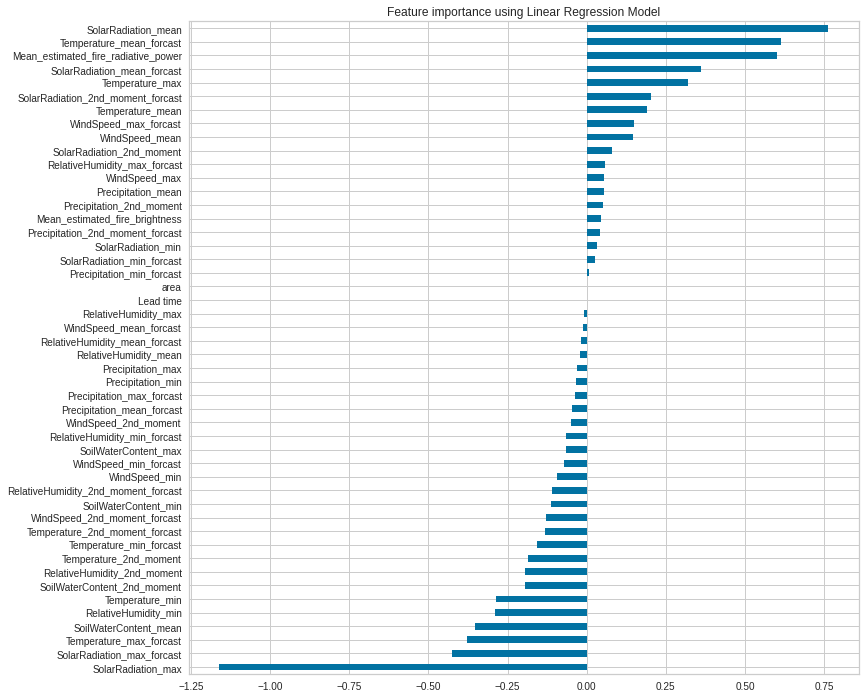

In [939]:
coef = pd.Series(regr.coef_, index = X_train.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Linear Regression Model")
plt.savefig('Linear-Regression-Feature-Importance.jpg')
plt.show()

<a class="anchor" id="model2"></a>
### 3.2 Decision tree model

In [940]:
#estimating MSLE for depth=6-24
R_MSLE1=[]
for i in range(6,24):
  tree = DecisionTreeRegressor(max_depth=i,random_state=42)
  tree.fit(X_train2, np.log(y_train))
  tree_pred = tree.predict(X_test2)
  r2_decision=result(np.log(y_test), tree_pred)
  print(i)
  print("MSLE : {}".format(r2_decision[0]))
  print("Root MSLE : {}".format(r2_decision[1]))
  R_MSLE1.append(r2_decision[1])
  print("R2 Score : {} or {}%".format(r2_decision[2],r2_decision[3]))


6
MSLE : 0.8095623455447867
Root MSLE : 0.8997568257839375
R2 Score : 0.6809099154459256 or 68.091%
7
MSLE : 0.7029091412357663
Root MSLE : 0.8383967683834226
R2 Score : 0.7229474190035137 or 72.2947%
8
MSLE : 0.6551254912578431
Root MSLE : 0.8093982278568709
R2 Score : 0.7417814087458321 or 74.1781%
9
MSLE : 0.5871338896440553
Root MSLE : 0.7662466245563861
R2 Score : 0.7685803897351353 or 76.858%
10
MSLE : 0.5244972255741926
Root MSLE : 0.7242218068894313
R2 Score : 0.7932687149076553 or 79.3269%
11
MSLE : 0.5075886728328202
Root MSLE : 0.7124525758482596
R2 Score : 0.7999332436541113 or 79.9933%
12
MSLE : 0.47440710585385476
Root MSLE : 0.688772172676753
R2 Score : 0.8130118027931603 or 81.3012%
13
MSLE : 0.4469674698263535
Root MSLE : 0.6685562577871466
R2 Score : 0.8238271721446787 or 82.3827%
14
MSLE : 0.4405321671675597
Root MSLE : 0.6637259729493488
R2 Score : 0.826363655320837 or 82.6364%
15
MSLE : 0.41550873886346656
Root MSLE : 0.6445996733349053
R2 Score : 0.836226673156742

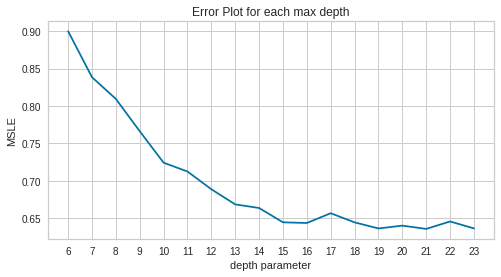

In [941]:
#plotting error
curve = pd.DataFrame(R_MSLE1) #elbow curve 
plt.figure(figsize=(8,4))
plt.xticks(list(range(6,24)), list(range(6,24)), rotation='horizontal')
plt.plot(list(range(6,24)),R_MSLE1)
plt.xlabel('depth parameter')
plt.ylabel('MSLE')
plt.title('Error Plot for each max depth')
plt.savefig('Decision-Error-Plot.jpg')
plt.show()

In [942]:
tree = DecisionTreeRegressor(max_depth=19,random_state=42)
tree.fit(X_train2, np.log(y_train))
tree_pred = tree.predict(X_test2)

print(tree.feature_importances_)

r2_decision=result(np.log(y_test), tree_pred)
print("MSLE : {}".format(r2_decision[0]))
print("Root MSLE : {}".format(r2_decision[1]))
print("R2 Score : {} or {}%".format(r2_decision[2],r2_decision[3]))
accu['Decision Tree']=r2_decision

[2.46060052e-02 4.77703251e-01 0.00000000e+00 6.79690511e-03
 7.65674665e-03 1.78083293e-02 9.33063136e-07 7.82188693e-03
 1.34086727e-02 4.97037232e-03 2.08312878e-02 1.90665777e-02
 3.36203828e-02 6.67078879e-02 1.95897068e-02 6.83300558e-03
 2.84413673e-02 2.43794006e-02 9.96552379e-03 1.14838459e-02
 8.45644033e-03 5.74114385e-03 1.53363718e-02 8.92712308e-03
 1.02945358e-02 1.87066876e-02 9.80308485e-03 3.42083369e-04
 3.98711086e-04 1.25120363e-03 9.98479531e-04 0.00000000e+00
 7.07787457e-04 1.51182395e-03 3.29179968e-03 2.92688076e-04
 2.99927953e-03 9.59816904e-02 1.65743982e-03 1.50863974e-03
 3.50706372e-03 6.98965885e-04 2.29689629e-03 1.56161773e-03
 6.77221759e-05 4.43086953e-04 6.23708468e-04 9.01836449e-04]
MSLE : 0.4049903746128986
Root MSLE : 0.6363885406046361
R2 Score : 0.8403725005368756 or 84.0373%


In [943]:
values = tree.feature_importances_
keys = X_train.columns 

importance = {keys[i]: values[i] for i in range(len(keys))}

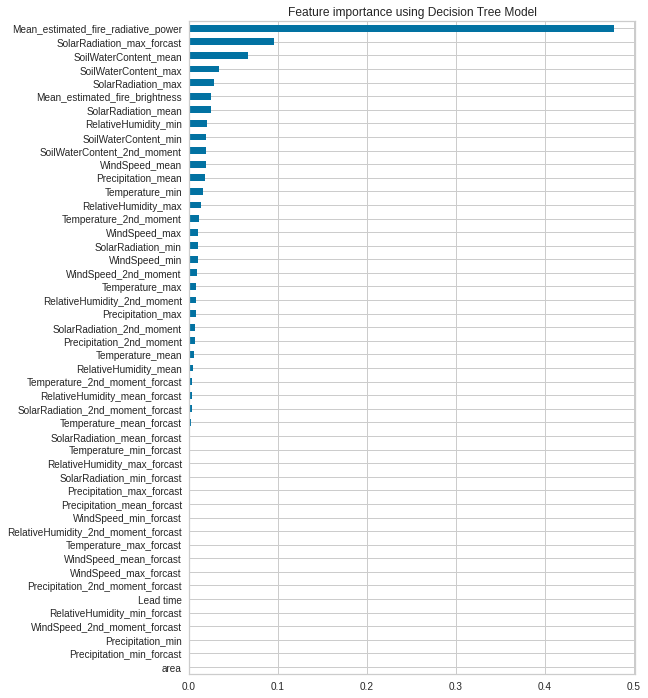

In [944]:
coef = pd.Series(tree.feature_importances_, index = X_train.columns)
imp_coef = coef.sort_values()
matplotlib.rcParams['figure.figsize'] = (8.0, 12.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Decision Tree Model")
plt.savefig('Decision-Tree-Feature-Importance.jpg')
plt.show()

#3.3 KNN Algorithm

In [945]:
#estimating MSLE for k=1-9
R_MSLE=[]
for i in range(1,10):
    KNN=KNeighborsRegressor(n_neighbors=i)
    KNN.fit(X_train2,np.log(y_train))
    y_pred=KNN.predict(X_test2)
    error=np.sqrt(mean_squared_error(np.log(y_test), y_pred))
    R_MSLE.append(error)
    print("K =",i," , Root MSLE =",error)
    print('Coefficient of determination (r2): %.2f' % r2_score(np.log(y_test), y_pred))

K = 1  , Root MSLE = 1.121425027129364
Coefficient of determination (r2): 0.50
K = 2  , Root MSLE = 1.0361144601173646
Coefficient of determination (r2): 0.58
K = 3  , Root MSLE = 1.0164294303429418
Coefficient of determination (r2): 0.59
K = 4  , Root MSLE = 1.0071234688592057
Coefficient of determination (r2): 0.60
K = 5  , Root MSLE = 1.0087945628582293
Coefficient of determination (r2): 0.60
K = 6  , Root MSLE = 1.016131794669489
Coefficient of determination (r2): 0.59
K = 7  , Root MSLE = 1.0231394182234315
Coefficient of determination (r2): 0.59
K = 8  , Root MSLE = 1.029890841610668
Coefficient of determination (r2): 0.58
K = 9  , Root MSLE = 1.036510991280585
Coefficient of determination (r2): 0.58


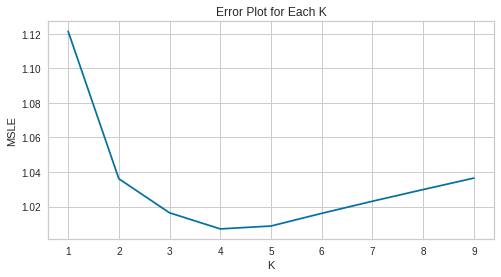

In [946]:
#plotting error

curve = pd.DataFrame(R_MSLE) #elbow curve 
plt.figure(figsize=(8,4))
plt.xticks(list(range(1,10)), list(range(1,10)), rotation='horizontal')
plt.plot(list(range(1,10)),R_MSLE)
plt.xlabel('K')
plt.ylabel('MSLE')
plt.title('Error Plot for Each K')
plt.savefig('KNN-Error-Plot.jpg')
plt.show()

In [947]:
#model implementation
KNN=KNeighborsRegressor(n_neighbors=4) 
KNN.fit(X_train2,np.log(y_train))
y_pred=KNN.predict(X_test2)
#model evaluation
r4_knn=result(np.log(y_test),y_pred)
print("MSLE : {}".format(r4_knn[0]))
print("Root MSLE : {}".format(r4_knn[1]))
print("R2 Score : {} or {}%".format(r4_knn[2],r4_knn[3]))
accu['KNN']=r4_knn

MSLE : 1.0142976815269993
Root MSLE : 1.0071234688592057
R2 Score : 0.6002132081085696 or 60.0213%


#Lasso Regression

In [948]:
#model object and fitting it
lasso=Lasso(alpha=0.0001)
lasso.fit(X_train2,np.log(y_train))
y_pred=lasso.predict(X_test2)
#model evaluation
# y_test_3,y_pred_3=remove_neg(y_test,y_pred)
r3_lasso=result(np.log(y_test), y_pred)
print("MSLE : {}".format(r3_lasso[0]))
print("Root MSLE : {}".format(r3_lasso[1]))
print("R2 Score : {} or {}%".format(r3_lasso[2],r3_lasso[3]))
accu['Lasso Regression']=r3_lasso

MSLE : 1.2828748205945106
Root MSLE : 1.1326406405363136
R2 Score : 0.49435316843902155 or 49.4353%


#ADA Boost

In [949]:
#model implementation
ABR = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=24),
    n_estimators=200,learning_rate=0.6
)

ABR.fit(X_train2, np.log(y_train))
y_pred = ABR.predict(X_test2)
#model evaluation
r7_ab=result(np.log(y_test),y_pred)
print("MSLE : {}".format(r7_ab[0]))
print("Root MSLE : {}".format(r7_ab[1]))
print("R2 Score : {} or {}%".format(r7_ab[2],r7_ab[3]))
accu['ADA Boost']=r7_ab

MSLE : 0.1256830476662032
Root MSLE : 0.35451804984542495
R2 Score : 0.9504618581539451 or 95.0462%


# XG Boost

In [950]:
xgb = XGBRegressor()
# fit model
xgb.fit(X_train2,np.log(y_train))
y_pred=xgb.predict(X_test2)
#model evaluation
r5_xgb=result(np.log(y_test),y_pred)
print("MSLE : {}".format(r5_xgb[0]))
print("Root MSLE : {}".format(r5_xgb[1]))
print("R2 Score : {} or {}%".format(r5_xgb[2],r5_xgb[3]))
accu['XG Boost']=r5_xgb

[15:20:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSLE : 0.5502976430566126
Root MSLE : 0.741820492475513
R2 Score : 0.7830994457447527 or 78.3099%


[2.46668551e-02 2.76277483e-01 0.00000000e+00 3.34606669e-03
 1.04422076e-02 2.95304712e-02 0.00000000e+00 1.63262989e-02
 2.64289714e-02 3.10692489e-02 1.47659462e-02 1.14964489e-02
 5.66238724e-02 9.11748856e-02 1.40102245e-02 1.19788842e-02
 4.69536148e-02 1.78812295e-02 9.31052864e-03 1.85853299e-02
 8.81013740e-03 1.38392905e-02 2.62020882e-02 1.16017060e-02
 9.42009781e-03 1.72770098e-02 1.29898163e-02 1.31198112e-03
 2.68995762e-04 0.00000000e+00 7.64521537e-03 0.00000000e+00
 7.58390548e-03 6.18178630e-03 1.12894718e-02 4.90816589e-03
 4.56399983e-03 8.00975561e-02 0.00000000e+00 0.00000000e+00
 8.27386603e-03 1.84204131e-02 1.11240884e-02 7.10268179e-03
 6.14699023e-03 4.59910929e-03 5.57701755e-03 3.89597286e-03]


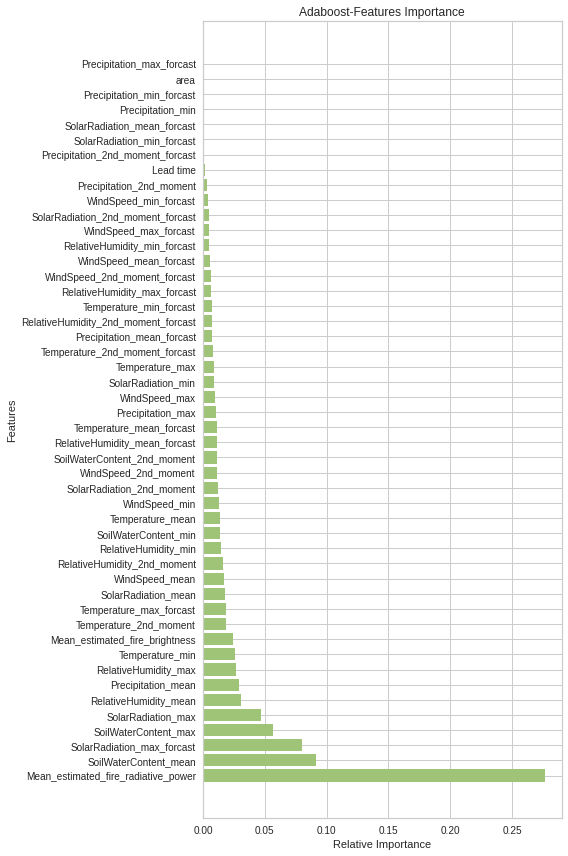

In [951]:
importances=xgb.feature_importances_
features=X_train.columns
print(importances)
indices = np.argsort(importances)
indices = [x for x in reversed(indices)]
plt.figure(1)
plt.title('Adaboost-Features Importance')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('XGB-Features-Importance2.jpg',dpi=60)
plt.show();

In [952]:
accu.to_csv('errors.csv')

In [953]:
accu=pd.read_csv('./errors.csv',index_col=0)
accu

,Linear Regression,Decision Tree,KNN,Lasso Regression,ADA Boost,XG Boost
MSLE,1.283387,0.404990,1.014298,1.282875,0.125683,0.550298
Root MSLE,1.132867,0.636389,1.007123,1.132641,0.354518,0.741820
R2 Score,0.494151,0.840373,0.600213,0.494353,0.950462,0.783099
Accuracy(%),49.415100,84.037300,60.021300,49.435300,95.046200,78.309900


Linear Regression    49.4151
Lasso Regression     49.4353
KNN                  60.0213
XG Boost             78.3099
Decision Tree        84.0373
ADA Boost            95.0462
Name: Accuracy(%), dtype: float64
49.4151


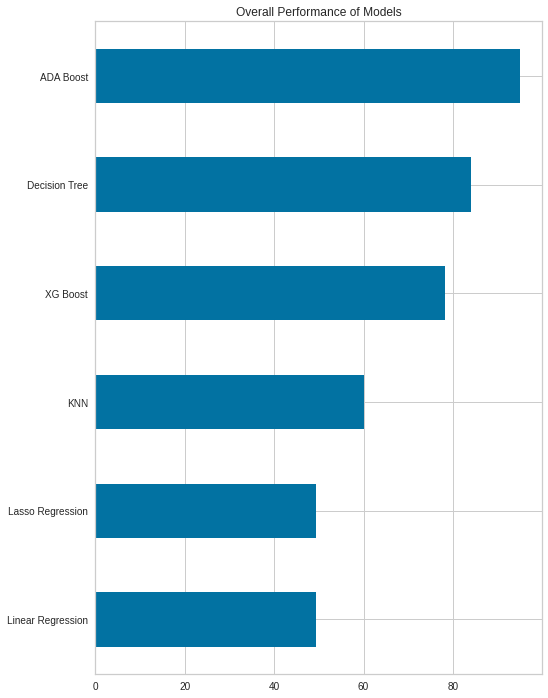

In [954]:
model_accuracy=accu.loc['Accuracy(%)']
model_accuracy.sort_values(ascending=True,inplace=True)
x=list(range(len(model_accuracy)))
print(model_accuracy)
# y=list(range(0,101,10))
# props = dict(boxstyle='round', facecolor='white', alpha=0.8)
# plt.figure(figsize=(10,3))
# plt.barh(model_accuracy)
# plt.yticks(y)
# plt.xticks(fontsize=10)
# plt.xticks(rotation = (10))
# plt.xlabel("Models",fontsize=15)
# plt.ylabel("Accuracy(%)",fontsize=15)
# plt.title("Performance of Models")
# for a in x:
#   b=model_accuracy[a]
#   val="("+str(round(model_accuracy[a],2))+" %)"
#   plt.text(a, b+4.5, val,horizontalalignment='center',verticalalignment='center',color='green',bbox=props)
#   plt.text(a, b+3.5, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)
# plt.tight_layout()
# plt.savefig('Overall-Performance.jpg',dpi=600)
# plt.show();
# ind = np.argsort(model_accuracy)
# # ind=list(range(0,6))
# print(ind)
# M=["Linear Regression", "Lasso Regression",	"XG Boost", "KNN", "Decision Tree",	"ADA Boost"]
# plt.figure(2)
# plt.barh(range(len(ind)), model_accuracy[ind], color='g', align='center')
# # plt.yticks(range(len(ind)), M[ind])
# plt.xlabel('Relative Importance')
# plt.ylabel('Features')
# plt.tight_layout()
# plt.title("Overall Performance of Models")
# plt.savefig('overall_perf.jpg')
# plt.show();

model_accuracy.plot(kind = "barh")
print(model_accuracy[0])
plt.title("Overall Performance of Models")
plt.savefig('overall_perf.jpg')
plt.show()
